# Alpine Resort Shutdown Model

Seq2Seq LSTM for predicting ski resort shutdown year based on weather sequences.

---

## Table of Contents
1. **Setup & Imports**
2. **Data Exploration** - Metadata (current/former resorts)
3. **Data Ingestion** - Load ski_weather, create years_until_closure target
4. **Label Sanity Check** - Verify years_until_closure is correct
5. **Preprocessing** - Sliding window sequences (15-year)
6. **Sanity Checks** - Split composition, regression baselines
7. **Model Definition** - LSTM Regression (MSE loss)
8. **Training** - With Early Stopping + LR Schedule
9. **Evaluation** - Regression test suite (MAE, RMSE, R2)
10. **Feature Importance** - Gradient-based saliency maps

---

## Data Sources
- `ski_weather`: Weekly weather data per resort (temperature)
- `current_resorts`: Metadata for currently open resorts
- `former_resorts`: Metadata for closed resorts, **including `year_closed`**

## Approach: Sliding Window (15-year sequences)
- **Fixed-length windows**: All sequences are exactly 15 years
- **Data augmentation**: Each resort generates multiple windows via sliding
- **No padding needed**: Eliminates padding-related metric issues
- **Resort-level split**: Train/val/test split by resort (prevents data leakage)

## Label Strategy: Multi-Task (Classification + Regression)
We predict two targets **per year** in the 15-year window:

- **Classification (`closed_target`)**
  - **current**: always `0`
  - **former**: `1` if `year >= year_closed` else `0`

- **Regression (`years_until_closure`)**
  - **former**: `max(0, year_closed - year)`
  - **current**: `50` (large value indicating "not closing")

This approach:
- Keeps the **"nice" probability curves** from classification
- Preserves **year-level timing resolution** via regression
- Still makes **no causal claims** (targets are derived from factual `year_closed`)


In [1]:
# =============================================================================
# 1. SETUP & IMPORTS
# =============================================================================

import numpy as np
import pandas as pd
import tensorflow as tf
import hopsworks
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reproducibility
load_dotenv()
tf.random.set_seed(42)
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

print("Setup complete.")


/Users/admin/Documents/KTH-Projects_Code/.venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
/Users/admin/Documents/KTH-Projects_Code/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete.


In [2]:
# =============================================================================
# 2. DATA EXPLORATION - Metadata (current/former resorts)
# =============================================================================

project = hopsworks.login(project='matteusbID2223')
fs = project.get_feature_store()

current_df = fs.get_feature_group(name='current_resorts', version=1).read()
former_df = fs.get_feature_group(name='former_resorts', version=1).read()


def describe_metadata_df(name: str, df: pd.DataFrame) -> None:
    print(f"\n=== {name} ===")
    print(f"shape: {df.shape}")
    print("columns:", list(df.columns))
    print("\ndtypes:")
    print(df.dtypes)
    if 'id' in df.columns:
        print(f"\nunique ids: {df['id'].nunique()} (rows: {len(df)})")
    # find closing/year/date columns
    candidate_cols = [c for c in df.columns if re.search(r"(close|shut|end|date|year)", str(c), re.IGNORECASE)]
    if candidate_cols:
        print("\npossible closing/year/date columns:", candidate_cols)
        for c in candidate_cols:
            try:
                sample = df[c].dropna().unique()[:10]
                print(f"- {c}: sample={sample}")
            except Exception as e:
                print(f"- {c}: (could not sample) {e}")
    print("\nhead(5):")
    print(df.head(5))


describe_metadata_df('current_resorts', current_df)
describe_metadata_df('former_resorts', former_df)

print("\n=== END METADATA EXPLORATION ===")


2026-01-06 09:25:09,793 INFO: Initializing external client
2026-01-06 09:25:09,793 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-06 09:25:11,464 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271967
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.76s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.87s) 

=== current_resorts ===
shape: (839, 4)
columns: ['id', 'name', 'latitude', 'longitude']

dtypes:
id             int64
name          object
latitude     float64
longitude    float64
dtype: object

unique ids: 839 (rows: 839)

head(5):
           id                                    name   latitude  longitude
0  1226505097                                 Torgnon  45.814452   7.554285
1   601135063               Font d'Urle Chaud Clapier  44.910152   5.323491
2  1254287966                     Ristolas en Queyras  44.771783   6.960893
3   601115623        

In [3]:
# =============================================================================
# 3. DATA INGESTION - Load ski_weather, create targets + attach geo (lat/lon)
# =============================================================================

# 1) Fetch weather data
ski_weather_fg = fs.get_feature_group(name='ski_weather', version=1)
print("Reading ski_weather data...")
df = ski_weather_fg.read()

# 2) Prepare ID sets + metadata lookups
current_ids = set(current_df['id'].astype(int))
former_ids = set(former_df['id'].astype(int))

# year_closed lookup for former resorts
year_closed_map = dict(zip(former_df['id'].astype(int), former_df['year_closed'].astype(int)))

# lat/lon lookup for all known resorts (current + former)
meta_geo = pd.concat([
    current_df[['id', 'latitude', 'longitude']],
    former_df[['id', 'latitude', 'longitude']],
], ignore_index=True)
meta_geo['id'] = meta_geo['id'].astype(int)
meta_geo = meta_geo.drop_duplicates(subset=['id'], keep='first')
meta_geo = meta_geo.rename(columns={'id': 'ski_resort_id'})

# 3) Standardize columns (we no longer rely on df['closed'])
required_cols = {'date', 'ski_resort_id', 'mean_week_temperature'}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns in ski_weather: {missing}")

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['ski_resort_id'] = df['ski_resort_id'].astype(int)

# 4) Tag resort type

def get_resort_type(res_id: int) -> str:
    if res_id in current_ids:
        return 'current'
    if res_id in former_ids:
        return 'former'
    return 'unknown'


df['resort_type'] = df['ski_resort_id'].apply(get_resort_type)
df['is_current'] = df['resort_type'] == 'current'

# Filter out unknown resorts
unknown_n = df.loc[df['resort_type'] == 'unknown', 'ski_resort_id'].nunique()
if unknown_n > 0:
    print(f"Warning: dropping {unknown_n} resorts with unknown resort_type")
df = df[df['resort_type'] != 'unknown'].copy()

# 5) Attach static geo features (latitude/longitude)
df = df.merge(meta_geo, on='ski_resort_id', how='left')
missing_geo_resorts = df.loc[df['latitude'].isna() | df['longitude'].isna(), 'ski_resort_id'].nunique()
if missing_geo_resorts > 0:
    print(f"Warning: dropping {missing_geo_resorts} resorts with missing latitude/longitude")
df = df.dropna(subset=['latitude', 'longitude']).copy()

# 6) Targets
# 6a) Regression target: years_until_closure (factually defined from year_closed)
CURRENT_RESORT_YEARS = 50  # Large value for "not closing"


def compute_years_until_closure(row) -> int:
    if row['resort_type'] == 'current':
        return CURRENT_RESORT_YEARS
    year_closed = year_closed_map.get(int(row['ski_resort_id']))
    if year_closed is None:
        return CURRENT_RESORT_YEARS
    return int(max(0, year_closed - int(row['year'])))


df['years_until_closure'] = df.apply(compute_years_until_closure, axis=1).astype(int)

# 6b) Classification target: closed_target (0/1 per year, derived from year_closed)
# - current: always 0
# - former: 1 if year >= year_closed else 0

def compute_closed_target(row) -> int:
    if row['resort_type'] == 'current':
        return 0
    year_closed = year_closed_map.get(int(row['ski_resort_id']))
    if year_closed is None:
        return 0
    return int(int(row['year']) >= int(year_closed))


df['closed_target'] = df.apply(compute_closed_target, axis=1).astype(int)

# 7) Print statistics
print("\n--- Resort counts by type ---")
print(df.groupby('resort_type')['ski_resort_id'].nunique())

print("\n--- years_until_closure statistics (former resorts) ---")
former_years = df[df['resort_type'] == 'former']['years_until_closure']
print(former_years.describe())

print("\n--- closed_target distribution (all rows) ---")
print(df['closed_target'].value_counts(normalize=True).rename('ratio'))

# Sort for sequence building
df = df.sort_values(by=['ski_resort_id', 'date']).reset_index(drop=True)
df.head()


Reading ski_weather data...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.20s) 

--- Resort counts by type ---
resort_type
current    100
former     241
Name: ski_resort_id, dtype: int64

--- years_until_closure statistics (former resorts) ---
count    178345.000000
mean          3.911890
std           5.010346
min           0.000000
25%           0.000000
50%           0.000000
75%           8.000000
max          15.000000
Name: years_until_closure, dtype: float64

--- closed_target distribution (all rows) ---
closed_target
0    0.640833
1    0.359167
Name: ratio, dtype: float64


,date,ski_resort_id,closed,mean_week_temperature,year,resort_type,is_current,latitude,longitude,years_until_closure,closed_target
0,1983-01-01 00:00:00+00:00,2,True,-3.333738,1983,former,False,46.5528,9.3217,15,0
1,1983-01-02 00:00:00+00:00,2,True,-6.916476,1983,former,False,46.5528,9.3217,15,0
2,1983-01-03 00:00:00+00:00,2,True,-5.876297,1983,former,False,46.5528,9.3217,15,0
3,1983-01-04 00:00:00+00:00,2,True,-3.860524,1983,former,False,46.5528,9.3217,15,0
4,1983-01-05 00:00:00+00:00,2,True,-2.804472,1983,former,False,46.5528,9.3217,15,0


In [4]:
# =============================================================================
# 4. LABEL SANITY CHECK - Verify years_until_closure is correct
# =============================================================================

print("\n=== LABEL SANITY CHECK (years_until_closure) ===")
print(f"df.shape: {df.shape}")
print(f"columns: {list(df.columns)}")

# Check years_until_closure for former resorts
former_df_check = df[df['resort_type'] == 'former'].copy()

# For each former resort, verify that years_until_closure reaches 0 at year_closed
resort_year_stats = (
    former_df_check.groupby(['ski_resort_id', 'year'], as_index=False)
    .agg(min_years_until=('years_until_closure', 'min'))
)

# Find the year where years_until_closure first becomes 0
first_zero = (
    resort_year_stats[resort_year_stats['min_years_until'] == 0]
    .groupby('ski_resort_id')['year'].min()
    .rename('first_zero_year')
)

# Merge with actual year_closed
check_df = first_zero.reset_index().merge(
    former_df[['id', 'year_closed']].rename(columns={'id': 'ski_resort_id'}),
    on='ski_resort_id', how='left'
)
check_df['matches'] = check_df['first_zero_year'] == check_df['year_closed']

print(f"\n[former] Resorts where years_until_closure=0 at year_closed: {check_df['matches'].mean():.1%}")

# Show distribution of years_until_closure
print("\n--- years_until_closure distribution (former resorts) ---")
print(former_df_check['years_until_closure'].describe())

print("\n--- Sample: former resort timeline ---")
sample_resort = former_df_check['ski_resort_id'].iloc[0]
sample_data = former_df_check[former_df_check['ski_resort_id'] == sample_resort][['year', 'years_until_closure']].drop_duplicates()
sample_year_closed = year_closed_map.get(sample_resort)
print(f"Resort {sample_resort} (closed {sample_year_closed}):")
print(sample_data.sort_values('year').head(20).to_string(index=False))

print("\n=== END LABEL SANITY CHECK ===")



=== LABEL SANITY CHECK (years_until_closure) ===
df.shape: (253545, 11)
columns: ['date', 'ski_resort_id', 'closed', 'mean_week_temperature', 'year', 'resort_type', 'is_current', 'latitude', 'longitude', 'years_until_closure', 'closed_target']

[former] Resorts where years_until_closure=0 at year_closed: 100.0%

--- years_until_closure distribution (former resorts) ---
count    178345.000000
mean          3.911890
std           5.010346
min           0.000000
25%           0.000000
50%           0.000000
75%           8.000000
max          15.000000
Name: years_until_closure, dtype: float64

--- Sample: former resort timeline ---
Resort 2 (closed 1998):
 year  years_until_closure
 1983                   15
 1984                   14
 1985                   13
 1986                   12
 1987                   11
 1988                   10
 1989                    9
 1990                    8
 1991                    7
 1992                    6
 1993                    5
 1994        

In [5]:
# =============================================================================
# 5. PREPROCESSING - Sliding window sequences (20-year) + GEO + MULTI-TASK TARGETS
# =============================================================================
# Fixed WINDOW_SIZE-year windows with sliding window approach (no variable-length padding).
# We build TWO inputs and TWO targets:
# - X_seq:    (N, 15, 52) weekly temperatures per year
# - X_static: (N, 2)      latitude/longitude
# - y_class:  (N, 15, 1)  closed_target (0/1)
# - y_reg:    (N, 15, 1)  years_until_closure

WINDOW_SIZE = 20  # years


def prepare_sliding_windows(df: pd.DataFrame, window_size: int = WINDOW_SIZE):
    """Create fixed-length windows per resort.

    Returns: resort_data[resort_id] = list of window dicts.
    """
    resort_data = {}

    resort_ids = df['ski_resort_id'].unique()
    print(f"Processing {len(resort_ids)} resorts with {window_size}-year sliding windows...")

    total_windows = 0

    for r_id in resort_ids:
        resort_df = df[df['ski_resort_id'] == r_id].copy()
        years = np.array(sorted(resort_df['year'].unique()), dtype=int)

        if len(years) < window_size:
            continue

        resort_type = str(resort_df['resort_type'].iloc[0])
        is_current = bool(resort_df['is_current'].iloc[0])

        # Static features (same for all windows of this resort)
        lat = float(resort_df['latitude'].iloc[0])
        lon = float(resort_df['longitude'].iloc[0])
        x_static = np.array([lat, lon], dtype=np.float32)

        windows = []

        for start_idx in range(len(years) - window_size + 1):
            window_years = years[start_idx:start_idx + window_size]

            window_X_seq = []
            window_y_reg = []
            window_y_class = []

            for year in window_years:
                year_data = resort_df[resort_df['year'] == year]
                temps = year_data['mean_week_temperature'].values.astype(np.float32)

                # Pad/truncate to 52 weeks (within-year padding only)
                if len(temps) < 52:
                    temps = np.pad(temps, (0, 52 - len(temps)), mode='edge')
                elif len(temps) > 52:
                    temps = temps[:52]

                window_X_seq.append(temps)

                # Targets are constant within each year (weekly rows duplicate them)
                window_y_reg.append(float(year_data['years_until_closure'].iloc[0]))
                window_y_class.append(float(year_data['closed_target'].iloc[0]))

            windows.append({
                'X_seq': np.array(window_X_seq, dtype=np.float32),          # (15, 52)
                'X_static': x_static,                                       # (2,)
                'y_reg': np.array(window_y_reg, dtype=np.float32),          # (15,)
                'y_class': np.array(window_y_class, dtype=np.float32),      # (15,)
                'years': window_years,
                'resort_id': int(r_id),
                'resort_type': resort_type,
                'is_current': is_current,
                'latitude': lat,
                'longitude': lon,
            })
            total_windows += 1

        if windows:
            resort_data[int(r_id)] = windows

    print(f"Created {total_windows} windows from {len(resort_data)} resorts")
    return resort_data


def split_by_resort(resort_data, test_size: float = 0.1, val_size: float = 0.2, random_state: int = 42):
    """Resort-level split with stratification by resort_type (70/20/10)."""
    resort_ids = list(resort_data.keys())
    resort_types = [resort_data[r_id][0]['resort_type'] for r_id in resort_ids]

    train_val_ids, test_ids = train_test_split(
        resort_ids,
        test_size=test_size,
        random_state=random_state,
        stratify=resort_types,
    )

    train_val_types = [resort_data[r_id][0]['resort_type'] for r_id in train_val_ids]
    val_ratio = val_size / (1 - test_size)
    train_ids, val_ids = train_test_split(
        train_val_ids,
        test_size=val_ratio,
        random_state=random_state,
        stratify=train_val_types,
    )

    def collect_windows(ids, shuffle: bool = True):
        X_seq_list, X_static_list = [], []
        y_reg_list, y_class_list = [], []
        meta_list = []

        for r_id in ids:
            for w in resort_data[r_id]:
                X_seq_list.append(w['X_seq'])
                X_static_list.append(w['X_static'])
                y_reg_list.append(w['y_reg'])
                y_class_list.append(w['y_class'])
                meta_list.append({
                    'id': w['resort_id'],
                    'years': w['years'],
                    'resort_type': w['resort_type'],
                    'is_current': w['is_current'],
                    'latitude': w['latitude'],
                    'longitude': w['longitude'],
                })

        if shuffle:
            idx = np.random.permutation(len(X_seq_list))
            X_seq_list = [X_seq_list[i] for i in idx]
            X_static_list = [X_static_list[i] for i in idx]
            y_reg_list = [y_reg_list[i] for i in idx]
            y_class_list = [y_class_list[i] for i in idx]
            meta_list = [meta_list[i] for i in idx]

        return (
            np.array(X_seq_list, dtype=np.float32),
            np.array(X_static_list, dtype=np.float32),
            np.array(y_reg_list, dtype=np.float32),
            np.array(y_class_list, dtype=np.float32),
            meta_list,
        )

    Xs_train, Xst_train, yreg_train, ycls_train, meta_train = collect_windows(train_ids)
    Xs_val, Xst_val, yreg_val, ycls_val, meta_val = collect_windows(val_ids)
    Xs_test, Xst_test, yreg_test, ycls_test, meta_test = collect_windows(test_ids)

    return (
        (Xs_train, Xst_train, yreg_train, ycls_train, meta_train),
        (Xs_val, Xst_val, yreg_val, ycls_val, meta_val),
        (Xs_test, Xst_test, yreg_test, ycls_test, meta_test),
    )


# --- Build windows + split ---
resort_data = prepare_sliding_windows(df, window_size=WINDOW_SIZE)

(train_pack, val_pack, test_pack) = split_by_resort(resort_data)
(X_seq_train, X_static_train, y_reg_train, y_class_train, meta_train) = train_pack
(X_seq_val, X_static_val, y_reg_val, y_class_val, meta_val) = val_pack
(X_seq_test, X_static_test, y_reg_test, y_class_test, meta_test) = test_pack

# Reshape targets for Keras seq2seq: (samples, timesteps, 1)
y_reg_train = y_reg_train[..., np.newaxis]
y_reg_val = y_reg_val[..., np.newaxis]
y_reg_test = y_reg_test[..., np.newaxis]

y_class_train = y_class_train[..., np.newaxis]
y_class_val = y_class_val[..., np.newaxis]
y_class_test = y_class_test[..., np.newaxis]

# --- Standardize inputs (fit on TRAIN only to avoid leakage) ---
# Sequence normalization: global mean/std over train windows
seq_mean = float(X_seq_train.mean())
seq_std = float(X_seq_train.std() + 1e-8)
X_seq_train = (X_seq_train - seq_mean) / seq_std
X_seq_val = (X_seq_val - seq_mean) / seq_std
X_seq_test = (X_seq_test - seq_mean) / seq_std

# Static normalization: per-feature mean/std over train
static_mean = X_static_train.mean(axis=0)
static_std = X_static_train.std(axis=0) + 1e-8
X_static_train = (X_static_train - static_mean) / static_std
X_static_val = (X_static_val - static_mean) / static_std
X_static_test = (X_static_test - static_mean) / static_std

print("\nData shapes (multi-input, multi-task):")
print(f"X_seq_train:    {X_seq_train.shape}")
print(f"X_static_train: {X_static_train.shape}")
print(f"y_reg_train:    {y_reg_train.shape}")
print(f"y_class_train:  {y_class_train.shape}")
print(f"X_seq_val:      {X_seq_val.shape} | X_static_val: {X_static_val.shape}")
print(f"X_seq_test:     {X_seq_test.shape} | X_static_test: {X_static_test.shape}")

print("\nSplit by resort (no data leakage):")
print(f"Train windows: {len(X_seq_train)} | Val windows: {len(X_seq_val)} | Test windows: {len(X_seq_test)}")

# Count unique resorts per split
train_resorts = len(set(m['id'] for m in meta_train))
val_resorts = len(set(m['id'] for m in meta_val))
test_resorts = len(set(m['id'] for m in meta_test))
print(f"Train resorts: {train_resorts} | Val resorts: {val_resorts} | Test resorts: {test_resorts}")

# Verify stratification
def show_distribution(name, meta_list):
    types = pd.Series([m['resort_type'] for m in meta_list])
    ratios = types.value_counts(normalize=True)
    print(f"  {name}: current={ratios.get('current', 0):.1%}, former={ratios.get('former', 0):.1%}")

print("\nStratification check (should be similar across splits):")
show_distribution("Train", meta_train)
show_distribution("Val  ", meta_val)
show_distribution("Test ", meta_test)


Processing 341 resorts with 20-year sliding windows...


Created 3995 windows from 339 resorts

Data shapes (multi-input, multi-task):
X_seq_train:    (2814, 20, 52)
X_static_train: (2814, 2)
y_reg_train:    (2814, 20, 1)
y_class_train:  (2814, 20, 1)
X_seq_val:      (783, 20, 52) | X_static_val: (783, 2)
X_seq_test:     (398, 20, 52) | X_static_test: (398, 2)

Split by resort (no data leakage):
Train windows: 2814 | Val windows: 783 | Test windows: 398
Train resorts: 237 | Val resorts: 68 | Test resorts: 34

Stratification check (should be similar across splits):
  Train: current=29.9%, former=70.1%
  Val  : current=30.7%, former=69.3%
  Test : current=30.2%, former=69.8%


In [6]:
# =============================================================================
# 6. SANITY CHECKS - Split composition, multi-task targets, basic baselines
# =============================================================================

print("\n=== SANITY CHECKS (Multi-Task) ===")


def _summarize_split(name, meta_list, y_class, y_reg):
    types = pd.Series([m.get('resort_type', 'unknown') for m in meta_list]).value_counts(dropna=False)
    unique_resorts = len(set(m['id'] for m in meta_list))
    print(f"\n[{name}] windows: {len(meta_list)}, unique resorts: {unique_resorts}")
    print(types)

    y_cls_flat = y_class.reshape(-1)
    y_reg_flat = y_reg.reshape(-1)

    print(f"  closed_target: pos_rate={(y_cls_flat == 1).mean():.1%}")
    print(f"  years_until_closure: mean={y_reg_flat.mean():.1f}, min={y_reg_flat.min():.0f}, max={y_reg_flat.max():.0f}")


_summarize_split('train', meta_train, y_class_train, y_reg_train)
_summarize_split('val', meta_val, y_class_val, y_reg_val)
_summarize_split('test', meta_test, y_class_test, y_reg_test)

# Basic baselines
print("\n--- Baselines ---")

# Classification baseline: always predict open (0)
y_cls_test = y_class_test.reshape(-1)
pred0 = np.zeros_like(y_cls_test)
baseline_acc = float((pred0 == y_cls_test).mean())
print(f"[class] Always-open baseline accuracy (test): {baseline_acc:.3f}")

# Regression baseline: always predict train mean
mean_reg = float(y_reg_train.mean())
y_reg_test_flat = y_reg_test.reshape(-1)
baseline_reg_mae = float(np.abs(y_reg_test_flat - mean_reg).mean())
print(f"[reg] Train-mean baseline: mean={mean_reg:.1f} years | MAE(test)={baseline_reg_mae:.2f} years")

# Quick check: standardized inputs are roughly centered
print("\n--- Standardization check (train) ---")
print(f"X_seq_train mean={X_seq_train.mean():.3f}, std={X_seq_train.std():.3f}")
print(f"X_static_train mean={X_static_train.mean(axis=0)}, std={X_static_train.std(axis=0)}")

print(f"\nWindow size: {WINDOW_SIZE} years")
print("\n=== END SANITY CHECKS ===")



=== SANITY CHECKS (Multi-Task) ===

[train] windows: 2814, unique resorts: 237
former     1974
current     840
Name: count, dtype: int64
  closed_target: pos_rate=36.7%
  years_until_closure: mean=16.9, min=0, max=50

[val] windows: 783, unique resorts: 68
former     543
current    240
Name: count, dtype: int64
  closed_target: pos_rate=36.1%
  years_until_closure: mean=17.3, min=0, max=50

[test] windows: 398, unique resorts: 34
former     278
current    120
Name: count, dtype: int64
  closed_target: pos_rate=36.5%
  years_until_closure: mean=17.0, min=0, max=50

--- Baselines ---
[class] Always-open baseline accuracy (test): 0.635
[reg] Train-mean baseline: mean=16.9 years | MAE(test)=19.82 years

--- Standardization check (train) ---
X_seq_train mean=0.000, std=1.000
X_static_train mean=[-1.5359634e-05  8.0087125e-07], std=[1.0000006 0.9999989]

Window size: 20 years

=== END SANITY CHECKS ===


In [7]:
# =============================================================================
# 7. MODEL DEFINITION - Hybrid Multi-Task LSTM (Geo + Dual Heads)
# =============================================================================
# NOTE: Training now uses WINDOW_SIZE-year windows (currently 20), but the MODEL supports inference on any length T.
# Inputs:
# - X_seq:    (T, 52) standardized weekly temperatures per year  (T can be 15, or any other length)
# - X_static: (2,)     standardized [lat, lon]
# Outputs (seq2seq):
# - class_out: (T, 1) probability of closed_target (sigmoid)
# - reg_out:   (T, 1) years_until_closure (relu)

from tensorflow.keras.layers import Concatenate, Lambda

DROPOUT_RATE = 0.3

class ResortShutdownMultiTaskModel:
    def __init__(self, n_features=52, dropout_rate=DROPOUT_RATE):
        self.model = self._build_architecture(n_features, dropout_rate)

    def _build_architecture(self, n_features, dropout_rate):
        # Inputs (dynamic time dimension)
        seq_in = Input(shape=(None, n_features), name='seq_in')
        static_in = Input(shape=(2,), name='static_in')

        # Sequence encoder (same size as before)
        x = LSTM(64, return_sequences=True, name='lstm_64')(seq_in)
        x = Dropout(dropout_rate, name='dropout_1')(x)
        x = LSTM(32, return_sequences=True, name='lstm_32')(x)
        x = Dropout(dropout_rate, name='dropout_2')(x)

        # Static embedding + broadcast across timesteps (works for any T)
        s = Dense(8, activation='relu', name='static_dense')(static_in)  # (batch, 8)

        def _broadcast_static(inputs):
            seq, stat = inputs  # seq: (batch, T, n_features), stat: (batch, 8)
            t = tf.shape(seq)[1]
            stat = tf.expand_dims(stat, axis=1)           # (batch, 1, 8)
            stat = tf.tile(stat, [1, t, 1])               # (batch, T, 8)
            return stat

        s_rep = Lambda(_broadcast_static, name='static_broadcast')([seq_in, s])

        # Combine
        h = Concatenate(name='concat_seq_static')([x, s_rep])
        h = TimeDistributed(Dense(32, activation='relu'), name='td_shared_dense')(h)

        # Heads
        class_out = TimeDistributed(Dense(1, activation='sigmoid'), name='class_out')(h)
        reg_out = TimeDistributed(Dense(1, activation='relu'), name='reg_out')(h)

        model = Model(inputs=[seq_in, static_in], outputs=[class_out, reg_out], name='shutdown_multitask')

        # Loss weights: keep classification dominant to preserve "nice" probability behavior
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss={'class_out': 'binary_crossentropy', 'reg_out': 'mse'},
            loss_weights={'class_out': 1.0, 'reg_out': 0.1},
            metrics={
                'class_out': [tf.keras.metrics.BinaryAccuracy(name='acc'), tf.keras.metrics.AUC(name='auc')],
                'reg_out': [tf.keras.metrics.MeanAbsoluteError(name='mae')],
            },
        )

        return model

    def train(
        self,
        X_seq,
        X_static,
        y_class,
        y_reg,
        X_seq_val,
        X_static_val,
        y_class_val,
        y_reg_val,
        epochs=30,
        batch_size=32,
        callbacks=None,
        verbose=2,
    ):
        """Train on fixed-length windows (we use WINDOW_SIZE-year windows for training)."""
        return self.model.fit(
            x={'seq_in': X_seq, 'static_in': X_static},
            y={'class_out': y_class, 'reg_out': y_reg},
            validation_data=(
                {'seq_in': X_seq_val, 'static_in': X_static_val},
                {'class_out': y_class_val, 'reg_out': y_reg_val},
            ),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose,
        )

    def predict(self, X_seq, X_static):
        """Return (class_probs, years_until) for a single window or batch.

        Supports any sequence length T at inference.
        - X_seq: (T, 52) or (N, T, 52)
        - X_static: (2,) or (N, 2)
        """
        if X_seq.ndim == 2:
            X_seq = np.expand_dims(X_seq, 0)
        if X_static.ndim == 1:
            X_static = np.expand_dims(X_static, 0)
        class_p, reg_y = self.model.predict({'seq_in': X_seq, 'static_in': X_static}, verbose=0)
        return class_p, reg_y


shutdown_model = ResortShutdownMultiTaskModel(n_features=52)
shutdown_model.model.summary()


Model: "shutdown_multitask"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, None, 52)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_64 (LSTM)      │ (None, None, 64)  │     29,952 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 64)  │          0 │ lstm_64[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_in           │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ (None, None, 32)  │     12,416 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_dense        │ (None, 8)         │         24 │ static_in[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 32)  │          0 │ lstm_32[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_broadcast    │ (None, None, 8)   │          0 │ seq_in[0][0],     │
│ (Lambda)            │                   │            │ static_dense[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_seq_static   │ (None, None, 40)  │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ static_broadcast… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_shared_dense     │ (None, None, 32)  │      1,312 │ concat_seq_stati… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_out           │ (None, None, 1)   │         33 │ td_shared_dense[… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reg_out             │ (None, None, 1)   │         33 │ td_shared_dense[… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,770 (170.98 KB)

 Trainable params: 43,770 (170.98 KB)

 Non-trainable params: 0 (0.00 B)

Starting multi-task training with Early Stopping + LR Schedule...
  - EarlyStopping: patience=7, restore_best_weights=True
  - ReduceLROnPlateau: factor=0.5, patience=3
  - Dropout: 0.3
  - Loss weights: class=1.0, reg=0.1

Epoch 1/100


88/88 - 4s - 42ms/step - class_out_acc: 0.4311 - class_out_auc: 0.4848 - class_out_loss: 0.8781 - loss: 57.6816 - reg_out_loss: 567.9272 - reg_out_mae: 17.0813 - val_class_out_acc: 0.6271 - val_class_out_auc: 0.3271 - val_class_out_loss: 0.7213 - val_loss: 44.4466 - val_reg_out_loss: 437.0108 - val_reg_out_mae: 18.2704 - learning_rate: 0.0010
Epoch 2/100
88/88 - 1s - 11ms/step - class_out_acc: 0.5924 - class_out_auc: 0.5081 - class_out_loss: 0.7196 - loss: 34.3378 - reg_out_loss: 336.0710 - reg_out_mae: 14.9565 - val_class_out_acc: 0.7498 - val_class_out_auc: 0.7725 - val_class_out_loss: 0.5582 - val_loss: 21.3747 - val_reg_out_loss: 207.6599 - val_reg_out_mae: 10.6003 - learning_rate: 0.0010
Epoch 3/100
88/88 - 1s - 10ms/step - class_out_acc: 0.7590 - class_out_auc: 0.8117 - class_out_loss: 0.5091 - loss: 14.4957 - reg_out_loss: 139.8601 - reg_out_mae: 7.5600 - val_class_out_acc: 0.7824 - val_class_out_auc: 0.8856 - val_class_out_loss: 0.4535 - val_loss: 16.0937 - val_reg_out_loss: 15

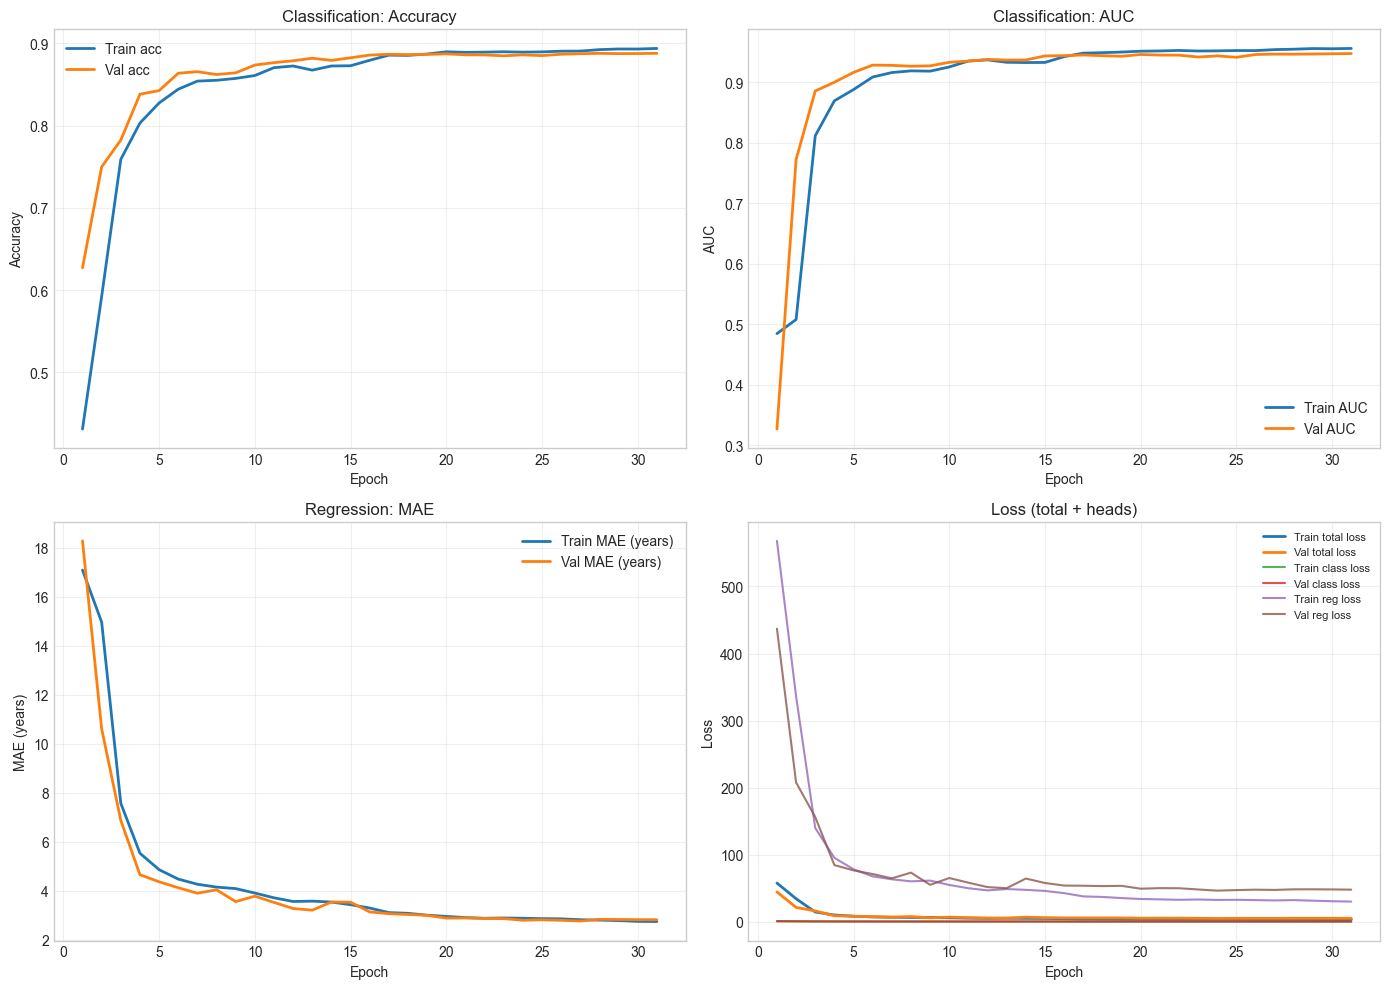


Final Val acc: 0.888 | Best Val acc: 0.888
Final Val AUC: 0.948 | Best Val AUC: 0.948
Final Val reg MAE: 2.81 years | Best Val reg MAE: 2.75 years


In [8]:
# =============================================================================
# 8. TRAINING - Multi-Task (Classification + Regression) with Early Stopping + LR Schedule
# =============================================================================

EPOCHS = 100

# Callbacks to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)

callbacks = [early_stopping, reduce_lr]

print("Starting multi-task training with Early Stopping + LR Schedule...")
print(f"  - EarlyStopping: patience=7, restore_best_weights=True")
print(f"  - ReduceLROnPlateau: factor=0.5, patience=3")
print(f"  - Dropout: {DROPOUT_RATE}")
print("  - Loss weights: class=1.0, reg=0.1")
print()

history = shutdown_model.train(
    X_seq_train,
    X_static_train,
    y_class_train,
    y_reg_train,
    X_seq_val,
    X_static_val,
    y_class_val,
    y_reg_val,
    epochs=EPOCHS,
    callbacks=callbacks,
)

# --- TRAINING CURVES (MULTI-TASK) ---
def plot_training_curves(history):
    """Plot training vs validation curves for both heads."""

    # Keys (safe access)
    h = history.history

    # Classification
    cls_acc = h.get('class_out_acc', [])
    cls_val_acc = h.get('val_class_out_acc', [])
    cls_auc = h.get('class_out_auc', [])
    cls_val_auc = h.get('val_class_out_auc', [])

    # Regression
    reg_mae = h.get('reg_out_mae', [])
    reg_val_mae = h.get('val_reg_out_mae', [])

    # Losses
    total_loss = h.get('loss', [])
    val_total_loss = h.get('val_loss', [])
    cls_loss = h.get('class_out_loss', [])
    val_cls_loss = h.get('val_class_out_loss', [])
    reg_loss = h.get('reg_out_loss', [])
    val_reg_loss = h.get('val_reg_out_loss', [])

    epochs = range(1, len(total_loss) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1) Accuracy
    ax = axes[0, 0]
    if cls_acc and cls_val_acc:
        ax.plot(epochs, cls_acc, label='Train acc', linewidth=2)
        ax.plot(epochs, cls_val_acc, label='Val acc', linewidth=2)
    ax.set_title('Classification: Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

    # 2) AUC
    ax = axes[0, 1]
    if cls_auc and cls_val_auc:
        ax.plot(epochs, cls_auc, label='Train AUC', linewidth=2)
        ax.plot(epochs, cls_val_auc, label='Val AUC', linewidth=2)
    ax.set_title('Classification: AUC')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUC')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

    # 3) Regression MAE
    ax = axes[1, 0]
    if reg_mae and reg_val_mae:
        ax.plot(epochs, reg_mae, label='Train MAE (years)', linewidth=2)
        ax.plot(epochs, reg_val_mae, label='Val MAE (years)', linewidth=2)
    ax.set_title('Regression: MAE')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MAE (years)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

    # 4) Loss breakdown
    ax = axes[1, 1]
    ax.plot(epochs, total_loss, label='Train total loss', linewidth=2)
    ax.plot(epochs, val_total_loss, label='Val total loss', linewidth=2)
    if cls_loss and val_cls_loss:
        ax.plot(epochs, cls_loss, label='Train class loss', alpha=0.8)
        ax.plot(epochs, val_cls_loss, label='Val class loss', alpha=0.8)
    if reg_loss and val_reg_loss:
        ax.plot(epochs, reg_loss, label='Train reg loss', alpha=0.8)
        ax.plot(epochs, val_reg_loss, label='Val reg loss', alpha=0.8)
    ax.set_title('Loss (total + heads)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Quick summary
    if cls_val_acc:
        print(f"\nFinal Val acc: {cls_val_acc[-1]:.3f} | Best Val acc: {max(cls_val_acc):.3f}")
    if cls_val_auc:
        print(f"Final Val AUC: {cls_val_auc[-1]:.3f} | Best Val AUC: {max(cls_val_auc):.3f}")
    if reg_val_mae:
        print(f"Final Val reg MAE: {reg_val_mae[-1]:.2f} years | Best Val reg MAE: {min(reg_val_mae):.2f} years")

plot_training_curves(history)


Running multi-task test suite on 398 windows...

MULTI-TASK TEST RESULTS

--- Classification (closed_target) ---
Accuracy: 0.848
AUC:      0.858
Confusion matrix [tn fp; fn tp]:
[[4531  520]
 [ 689 2220]]

--- Regression (years_until_closure) ---
MAE:  6.30 years
RMSE: 14.68 years
R2:   0.551

VISUALIZATIONS


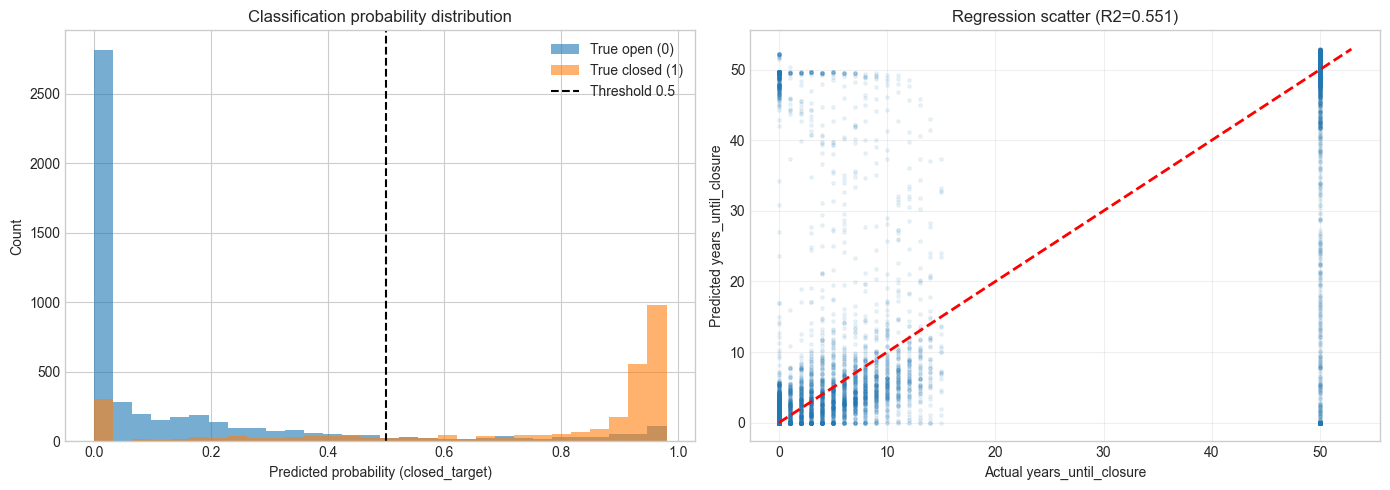

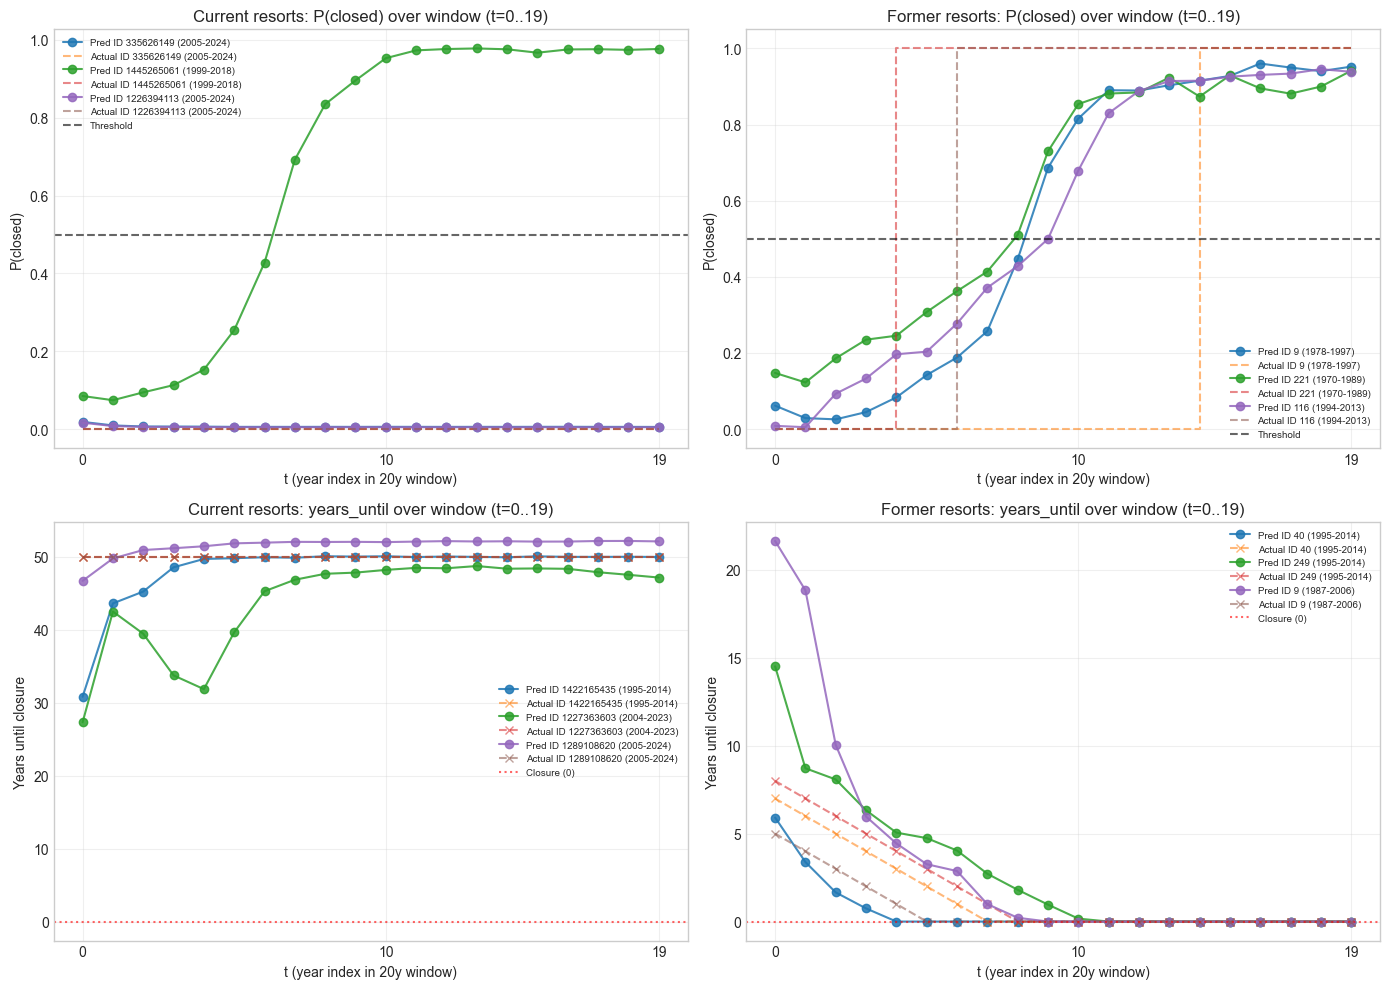

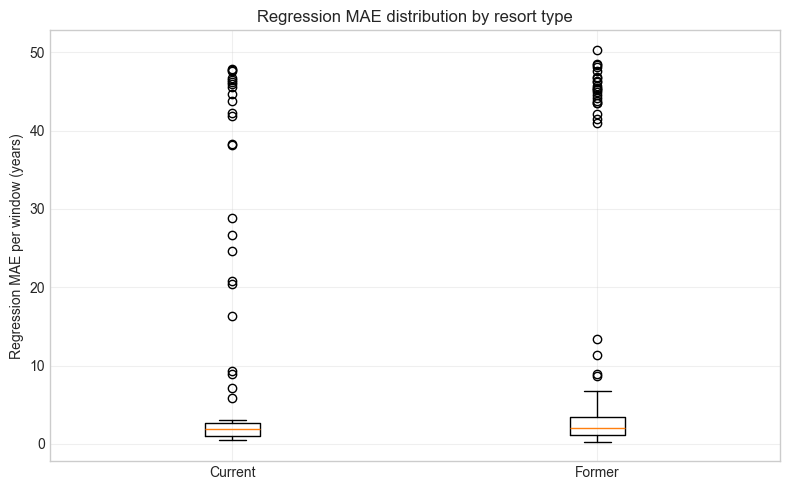

In [9]:
# =============================================================================
# 9. EVALUATION - Multi-Task test suite (Classification + Regression)
# =============================================================================

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    confusion_matrix,
)


def run_test_suite(
    X_seq_test,
    X_static_test,
    y_class_test,
    y_reg_test,
    meta_test,
    threshold: float = 0.5,
    closure_threshold_years: float = 2.0,
):
    """Evaluate both heads + produce "nice" plots.

    - Classification head predicts closed_target (per year)
    - Regression head predicts years_until_closure (per year)
    """

    print(f"Running multi-task test suite on {len(X_seq_test)} windows...")

    # Predict in one batch for speed
    pred_class, pred_reg = shutdown_model.model.predict(
        {'seq_in': X_seq_test, 'static_in': X_static_test},
        verbose=0,
    )

    # Flatten timestep-level arrays
    y_class_true = y_class_test.reshape(-1)
    y_reg_true = y_reg_test.reshape(-1)
    y_class_prob = pred_class.reshape(-1)
    y_reg_pred = pred_reg.reshape(-1)

    # --- CLASSIFICATION METRICS ---
    y_class_pred = (y_class_prob >= threshold).astype(int)

    # AUC can fail if only one class is present; guard it.
    auc = None
    if len(np.unique(y_class_true)) > 1:
        auc = float(roc_auc_score(y_class_true, y_class_prob))

    cm = confusion_matrix(y_class_true, y_class_pred)
    acc = float((y_class_pred == y_class_true).mean())

    # --- REGRESSION METRICS ---
    reg_mae = float(mean_absolute_error(y_reg_true, y_reg_pred))
    reg_rmse = float(np.sqrt(mean_squared_error(y_reg_true, y_reg_pred)))
    reg_r2 = float(r2_score(y_reg_true, y_reg_pred))

    print("\n" + "=" * 60)
    print("MULTI-TASK TEST RESULTS")
    print("=" * 60)

    print("\n--- Classification (closed_target) ---")
    print(f"Accuracy: {acc:.3f}")
    if auc is not None:
        print(f"AUC:      {auc:.3f}")
    else:
        print("AUC:      (skipped: only one class present)")
    print("Confusion matrix [tn fp; fn tp]:")
    print(cm)

    print("\n--- Regression (years_until_closure) ---")
    print(f"MAE:  {reg_mae:.2f} years")
    print(f"RMSE: {reg_rmse:.2f} years")
    print(f"R2:   {reg_r2:.3f}")

    # --- Per-window summary table ---
    results = []
    for i in range(len(X_seq_test)):
        years = np.array(meta_test[i]['years'], dtype=int)
        p_seq = pred_class[i, :, 0]
        y_seq = y_class_test[i, :, 0]
        r_pred_seq = pred_reg[i, :, 0]
        r_true_seq = y_reg_test[i, :, 0]

        # Actual closure year from y_class (first year where becomes 1)
        actual_idx = np.where(y_seq >= 0.5)[0]
        # Pred closure year from prob (first year prob >= threshold)
        pred_idx = np.where(p_seq >= threshold)[0]

        actual_closure_year = int(years[actual_idx[0]]) if len(actual_idx) else None
        pred_closure_year = int(years[pred_idx[0]]) if len(pred_idx) else None

        # Regression-derived closure year: first year where years_until <= closure_threshold_years
        reg_idx = np.where(r_pred_seq <= closure_threshold_years)[0]
        reg_closure_year = int(years[reg_idx[0]]) if len(reg_idx) else None

        results.append({
            'id': meta_test[i]['id'],
            'resort_type': meta_test[i]['resort_type'],
            'is_current': meta_test[i]['is_current'],
            'window': f"{years[0]}-{years[-1]}",
            'actual_closure_year': actual_closure_year,
            'pred_closure_year_cls': pred_closure_year,
            'pred_closure_year_reg': reg_closure_year,
            'final_prob': float(p_seq[-1]),
            'final_years_pred': float(r_pred_seq[-1]),
            'final_years_actual': float(r_true_seq[-1]),
            'mae_reg_window': float(np.abs(r_pred_seq - r_true_seq).mean()),
        })

    res_df = pd.DataFrame(results)

    # --- VISUALIZATIONS ---
    print("\n" + "=" * 60)
    print("VISUALIZATIONS")
    print("=" * 60)

    # Figure 1: Classification quality (prob histogram) + Regression scatter
    fig1, axes1 = plt.subplots(1, 2, figsize=(14, 5))

    # 1A) Prob distribution by true label
    axes1[0].hist(y_class_prob[y_class_true == 0], bins=30, alpha=0.6, label='True open (0)')
    axes1[0].hist(y_class_prob[y_class_true == 1], bins=30, alpha=0.6, label='True closed (1)')
    axes1[0].axvline(x=threshold, color='black', linestyle='--', label=f'Threshold {threshold}')
    axes1[0].set_xlabel('Predicted probability (closed_target)')
    axes1[0].set_ylabel('Count')
    axes1[0].set_title('Classification probability distribution')
    axes1[0].legend(loc='best')

    # 1B) Regression scatter (all timesteps)
    axes1[1].scatter(y_reg_true, y_reg_pred, alpha=0.08, s=6)
    max_val = max(float(y_reg_true.max()), float(y_reg_pred.max()))
    axes1[1].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
    axes1[1].set_xlabel('Actual years_until_closure')
    axes1[1].set_ylabel('Predicted years_until_closure')
    axes1[1].set_title(f'Regression scatter (R2={reg_r2:.3f})')
    axes1[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Figure 2: "Nice" probability curves + regression curves
    fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))

    current_indices = [i for i, m in enumerate(meta_test) if m['resort_type'] == 'current']
    former_indices = [i for i, m in enumerate(meta_test) if m['resort_type'] == 'former']

    # NOTE: plotting multiple resorts with different calendar-year ranges in the same axes looks "scuffed".
    # We therefore plot against the relative window index t=0..(WINDOW_SIZE-1) (aligned for all samples).

    def plot_prob_sample(ax, indices, title, n_samples=3):
        if len(indices) == 0:
            ax.text(0.5, 0.5, 'No samples', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title)
            return

        sample_n = min(n_samples, len(indices))
        sample_idx = np.random.choice(indices, sample_n, replace=False)

        for idx in sample_idx:
            years = np.array(meta_test[idx]['years'], dtype=int)
            t = np.arange(len(years))

            p = pred_class[idx, :, 0]
            y = y_class_test[idx, :, 0]

            label = f"ID {meta_test[idx]['id']} ({years[0]}-{years[-1]})"
            ax.plot(t, p, marker='o', alpha=0.85, label=f"Pred {label}")

            # Use a step plot for binary ground truth (much clearer than scatter)
            ax.step(t, y, where='post', linestyle='--', alpha=0.55, label=f"Actual {label}")

        ax.axhline(y=threshold, color='black', linestyle='--', alpha=0.6, label='Threshold')
        ax.set_xlabel(f't (year index in {WINDOW_SIZE}y window)')
        ax.set_ylabel('P(closed)')
        ax.set_title(title)
        ax.set_xticks([0, WINDOW_SIZE // 2, WINDOW_SIZE - 1])
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=7)

    def plot_reg_sample(ax, indices, title, n_samples=3):
        if len(indices) == 0:
            ax.text(0.5, 0.5, 'No samples', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title)
            return

        sample_n = min(n_samples, len(indices))
        sample_idx = np.random.choice(indices, sample_n, replace=False)

        for idx in sample_idx:
            years = np.array(meta_test[idx]['years'], dtype=int)
            t = np.arange(len(years))

            r_pred = pred_reg[idx, :, 0]
            r_true = y_reg_test[idx, :, 0]

            label = f"ID {meta_test[idx]['id']} ({years[0]}-{years[-1]})"
            ax.plot(t, r_pred, marker='o', alpha=0.85, label=f"Pred {label}")
            ax.plot(t, r_true, marker='x', linestyle='--', alpha=0.55, label=f"Actual {label}")

        ax.axhline(y=0, color='red', linestyle=':', alpha=0.6, label='Closure (0)')
        ax.set_xlabel(f't (year index in {WINDOW_SIZE}y window)')
        ax.set_ylabel('Years until closure')
        ax.set_title(title)
        ax.set_xticks([0, WINDOW_SIZE // 2, WINDOW_SIZE - 1])
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=7)

    plot_prob_sample(axes2[0, 0], current_indices, f'Current resorts: P(closed) over window (t=0..{WINDOW_SIZE-1})')
    plot_prob_sample(axes2[0, 1], former_indices, f'Former resorts: P(closed) over window (t=0..{WINDOW_SIZE-1})')
    plot_reg_sample(axes2[1, 0], current_indices, f'Current resorts: years_until over window (t=0..{WINDOW_SIZE-1})')
    plot_reg_sample(axes2[1, 1], former_indices, f'Former resorts: years_until over window (t=0..{WINDOW_SIZE-1})')

    plt.tight_layout()
    plt.show()

    # Figure 3: MAE distribution by resort type (regression)
    fig3, ax3 = plt.subplots(1, 1, figsize=(8, 5))
    current_mae = res_df[res_df['resort_type'] == 'current']['mae_reg_window'].values
    former_mae = res_df[res_df['resort_type'] == 'former']['mae_reg_window'].values
    ax3.boxplot([current_mae, former_mae], tick_labels=['Current', 'Former'])
    ax3.set_ylabel('Regression MAE per window (years)')
    ax3.set_title('Regression MAE distribution by resort type')
    ax3.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return res_df


test_results_df = run_test_suite(
    X_seq_test,
    X_static_test,
    y_class_test,
    y_reg_test,
    meta_test,
)


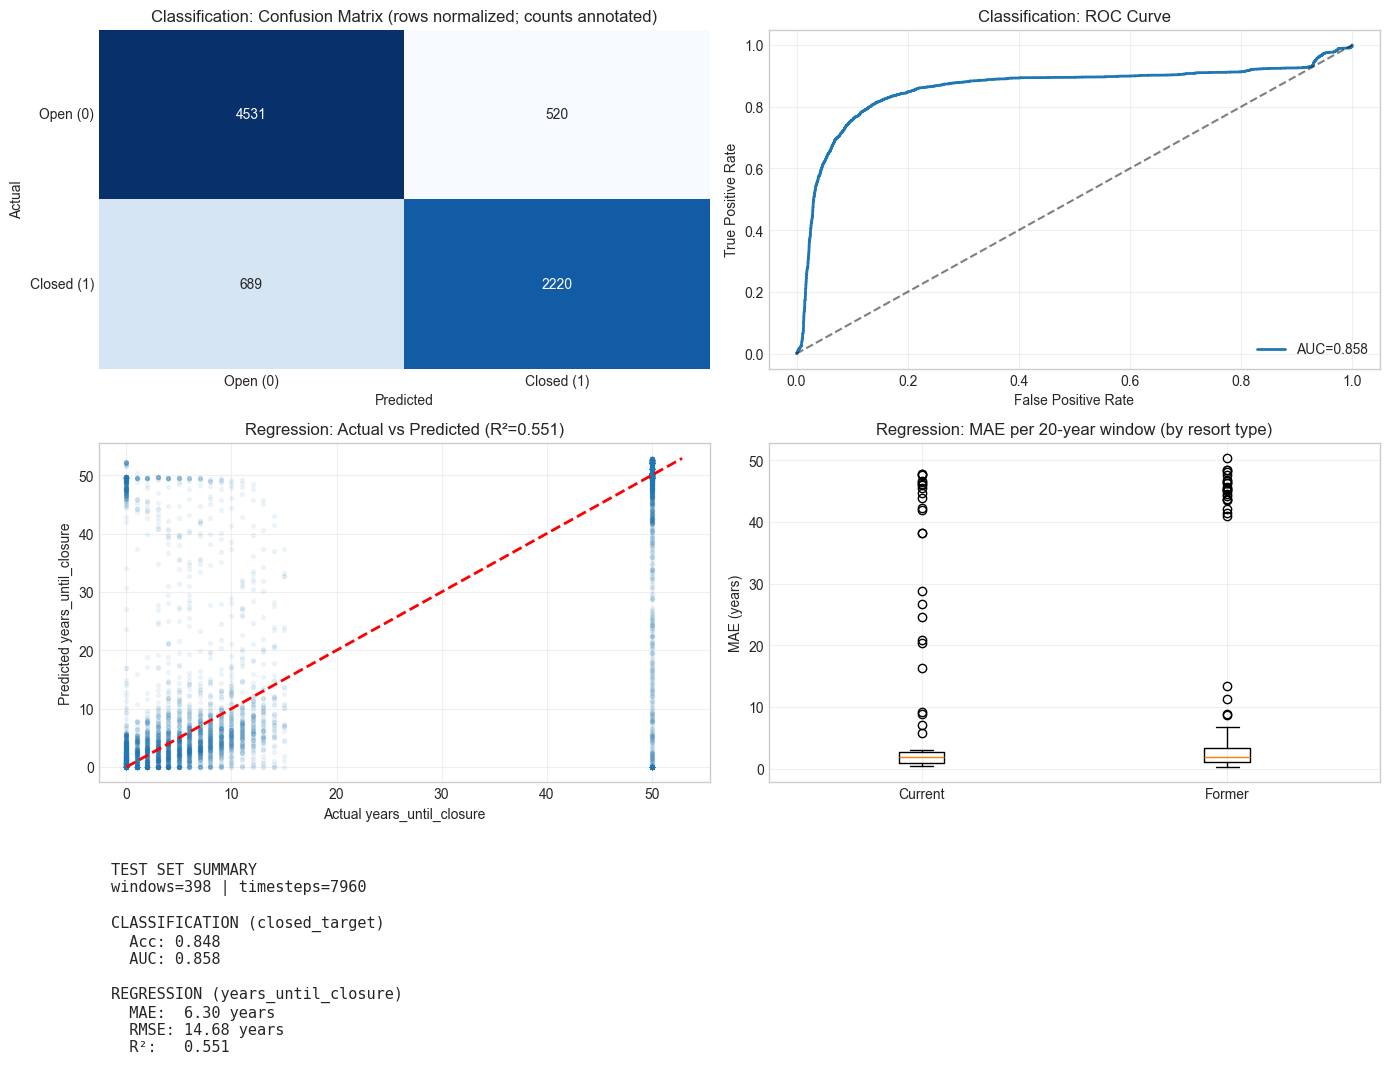

Saved partner summary figure to: /Users/admin/Documents/KTH-Projects_Code/Year-5/P2/ID2223-Project/shutdown_model/test_set_summary.png


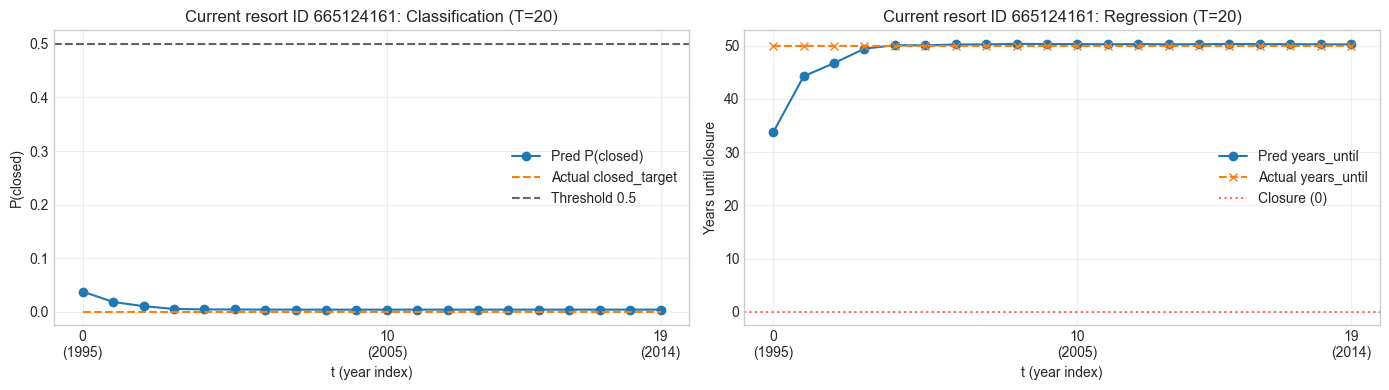

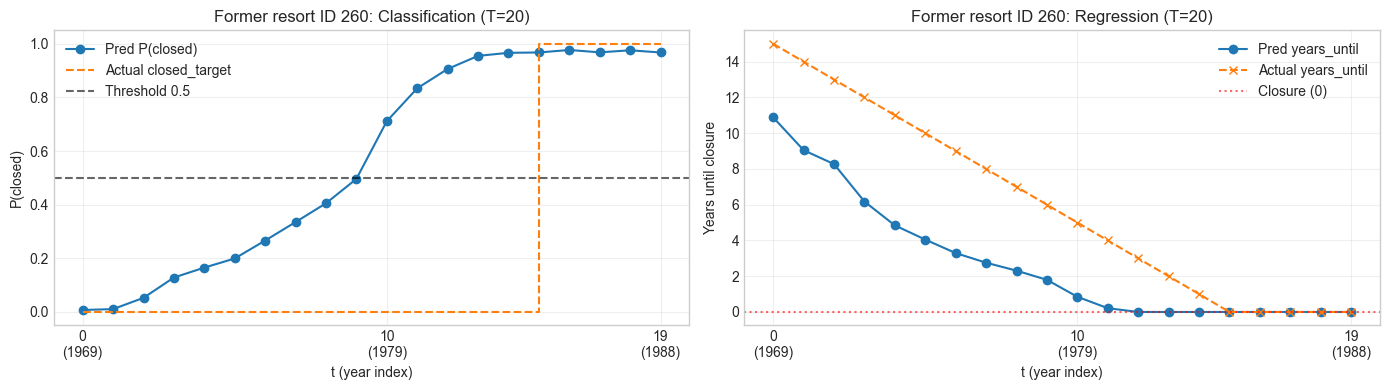

In [10]:
# =============================================================================
# 9c. PARTNER SUMMARY FIGURE - Overall test-set performance (shareable)
# =============================================================================

from sklearn.metrics import roc_curve, auc as sk_auc, mean_squared_error

# Predict on the entire test set (batch)
pred_class, pred_reg = shutdown_model.model.predict(
    {'seq_in': X_seq_test, 'static_in': X_static_test},
    verbose=0,
)

# Flatten timestep-level arrays
p_cls = pred_class.reshape(-1)
y_cls = y_class_test.reshape(-1)

y_hat = (p_cls >= 0.5).astype(int)
cm = confusion_matrix(y_cls, y_hat)
acc = float((y_hat == y_cls).mean())
auc_val = float(roc_auc_score(y_cls, p_cls)) if len(np.unique(y_cls)) > 1 else float('nan')

# Regression
p_reg = pred_reg.reshape(-1)
y_reg = y_reg_test.reshape(-1)
reg_mae = float(mean_absolute_error(y_reg, p_reg))
reg_rmse = float(np.sqrt(mean_squared_error(y_reg, p_reg)))
reg_r2 = float(r2_score(y_reg, p_reg))

# Per-window regression MAE by resort type
mae_by_type = {'current': [], 'former': []}
for i in range(len(meta_test)):
    rt = meta_test[i]['resort_type']
    mae_i = float(np.abs(pred_reg[i, :, 0] - y_reg_test[i, :, 0]).mean())
    if rt in mae_by_type:
        mae_by_type[rt].append(mae_i)

# ROC curve
fpr, tpr, _ = roc_curve(y_cls, p_cls) if len(np.unique(y_cls)) > 1 else (np.array([0, 1]), np.array([0, 1]), None)
roc_auc = sk_auc(fpr, tpr) if len(np.unique(y_cls)) > 1 else float('nan')

# --- Plot (no overlap: dedicate a bottom text panel) ---
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 11))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.35])

ax_cm = fig.add_subplot(gs[0, 0])
ax_roc = fig.add_subplot(gs[0, 1])
ax_scatter = fig.add_subplot(gs[1, 0])
ax_box = fig.add_subplot(gs[1, 1])
ax_txt = fig.add_subplot(gs[2, :])
ax_txt.axis('off')

# 1) Confusion matrix heatmap
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-9)
sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues', cbar=False, ax=ax_cm)
ax_cm.set_title('Classification: Confusion Matrix (rows normalized; counts annotated)')
ax_cm.set_xlabel('Predicted')
ax_cm.set_ylabel('Actual')
ax_cm.set_xticklabels(['Open (0)', 'Closed (1)'], rotation=0)
ax_cm.set_yticklabels(['Open (0)', 'Closed (1)'], rotation=0)

# 2) ROC curve
ax_roc.plot(fpr, tpr, linewidth=2, label=f'AUC={roc_auc:.3f}')
ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax_roc.set_title('Classification: ROC Curve')
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.grid(True, alpha=0.3)
ax_roc.legend(loc='lower right')

# 3) Regression scatter
ax_scatter.scatter(y_reg, p_reg, alpha=0.06, s=8)
max_val = float(max(y_reg.max(), p_reg.max()))
ax_scatter.plot([0, max_val], [0, max_val], 'r--', linewidth=2)
ax_scatter.set_title(f'Regression: Actual vs Predicted (R²={reg_r2:.3f})')
ax_scatter.set_xlabel('Actual years_until_closure')
ax_scatter.set_ylabel('Predicted years_until_closure')
ax_scatter.grid(True, alpha=0.3)

# 4) MAE distribution by type (per-window)
ax_box.boxplot(
    [mae_by_type['current'], mae_by_type['former']],
    tick_labels=['Current', 'Former'],
    showfliers=True,
)
ax_box.set_title(f'Regression: MAE per {WINDOW_SIZE}-year window (by resort type)')
ax_box.set_ylabel('MAE (years)')
ax_box.grid(True, alpha=0.3)

# Metrics summary (in its own panel)
summary = (
    f"TEST SET SUMMARY\n"
    f"windows={len(X_seq_test)} | timesteps={len(y_cls)}\n\n"
    f"CLASSIFICATION (closed_target)\n"
    f"  Acc: {acc:.3f}\n"
    f"  AUC: {auc_val:.3f}\n\n"
    f"REGRESSION (years_until_closure)\n"
    f"  MAE:  {reg_mae:.2f} years\n"
    f"  RMSE: {reg_rmse:.2f} years\n"
    f"  R²:   {reg_r2:.3f}\n"
)
ax_txt.text(0.01, 0.95, summary, fontsize=11, family='monospace', va='top', ha='left')

fig.tight_layout()

# Save to disk for sharing
out_path = '/Users/admin/Documents/KTH-Projects_Code/Year-5/P2/ID2223-Project/shutdown_model/test_set_summary.png'
plt.savefig(out_path, dpi=200, bbox_inches='tight', pad_inches=0.2)
plt.show()

print(f"Saved partner summary figure to: {out_path}")

# =============================================================================
# 9d. INFERENCE DEMO - 20-year sequence (model supports any T at inference)
# =============================================================================

INFER_T = WINDOW_SIZE  # default inference length matches training window


def _find_consecutive_years(years: np.ndarray, length: int):
    years = np.array(sorted(set(years)), dtype=int)
    if len(years) < length:
        return None
    for i in range(len(years) - length + 1):
        if years[i + length - 1] - years[i] == length - 1:
            return years[i:i + length]
    # fallback: last N years (may have gaps)
    return years[-length:]


def _build_X_seq(resort_id: int, years: np.ndarray) -> np.ndarray:
    X = []
    for yr in years:
        year_data = df[(df['ski_resort_id'] == resort_id) & (df['year'] == int(yr))]
        temps = year_data['mean_week_temperature'].values.astype(np.float32)
        if len(temps) < 52:
            temps = np.pad(temps, (0, 52 - len(temps)), mode='edge')
        elif len(temps) > 52:
            temps = temps[:52]
        X.append(temps)
    return np.array(X, dtype=np.float32)


def _build_targets(resort_id: int, years: np.ndarray):
    y_cls = []
    y_reg = []
    for yr in years:
        year_data = df[(df['ski_resort_id'] == resort_id) & (df['year'] == int(yr))]
        y_cls.append(float(year_data['closed_target'].iloc[0]))
        y_reg.append(float(year_data['years_until_closure'].iloc[0]))
    return np.array(y_cls, dtype=np.float32), np.array(y_reg, dtype=np.float32)


def _infer_and_plot(resort_id: int, title_prefix: str):
    resort_years = df.loc[df['ski_resort_id'] == resort_id, 'year'].unique()
    years20 = _find_consecutive_years(resort_years, INFER_T)
    if years20 is None:
        print(f"[SKIP] Resort {resort_id} has <{INFER_T} years")
        return

    # Build inputs
    X_seq_20 = _build_X_seq(resort_id, years20)
    lat = float(df.loc[df['ski_resort_id'] == resort_id, 'latitude'].iloc[0])
    lon = float(df.loc[df['ski_resort_id'] == resort_id, 'longitude'].iloc[0])
    X_static_20 = np.array([lat, lon], dtype=np.float32)

    # Normalize using TRAIN stats from Cell 5
    X_seq_20n = (X_seq_20 - seq_mean) / seq_std
    X_static_20n = (X_static_20 - static_mean) / static_std

    # Predict
    p_cls_20, p_reg_20 = shutdown_model.predict(X_seq_20n, X_static_20n)
    p_cls_20 = p_cls_20[0, :, 0]
    p_reg_20 = p_reg_20[0, :, 0]

    # True targets (for reference)
    y_cls_20, y_reg_20 = _build_targets(resort_id, years20)

    # Plot
    t = np.arange(INFER_T)
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    ax = axes[0]
    ax.plot(t, p_cls_20, marker='o', label='Pred P(closed)')
    ax.step(t, y_cls_20, where='post', linestyle='--', label='Actual closed_target')
    ax.axhline(0.5, color='black', linestyle='--', alpha=0.6, label='Threshold 0.5')
    ax.set_title(f"{title_prefix}: Classification (T={INFER_T})")
    ax.set_xlabel('t (year index)')
    ax.set_ylabel('P(closed)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

    ax = axes[1]
    ax.plot(t, p_reg_20, marker='o', label='Pred years_until')
    ax.plot(t, y_reg_20, marker='x', linestyle='--', label='Actual years_until')
    ax.axhline(0, color='red', linestyle=':', alpha=0.6, label='Closure (0)')
    ax.set_title(f"{title_prefix}: Regression (T={INFER_T})")
    ax.set_xlabel('t (year index)')
    ax.set_ylabel('Years until closure')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

    # annotate actual calendar years at a few ticks
    tick_pos = [0, INFER_T // 2, INFER_T - 1]
    tick_lbl = [str(int(years20[i])) for i in tick_pos]
    for a in axes:
        a.set_xticks(tick_pos)
        a.set_xticklabels([f"{tp}\n({yl})" for tp, yl in zip(tick_pos, tick_lbl)])

    plt.tight_layout()
    plt.show()


# Pick one current + one former resort from the test set (by resort id) and run 20-year inference
current_ids_test = list({m['id'] for m in meta_test if m['resort_type'] == 'current'})
former_ids_test = list({m['id'] for m in meta_test if m['resort_type'] == 'former'})

if current_ids_test:
    _infer_and_plot(int(current_ids_test[0]), title_prefix=f"Current resort ID {int(current_ids_test[0])}")
else:
    print("No current resorts in test split.")

if former_ids_test:
    _infer_and_plot(int(former_ids_test[0]), title_prefix=f"Former resort ID {int(former_ids_test[0])}")
else:
    print("No former resorts in test split.")




In [11]:
# =============================================================================
# 9b. SAMPLE TEST RESULTS (Multi-Task)
# =============================================================================

current_sample = test_results_df[test_results_df['resort_type'] == 'current'].head(5)
former_sample = test_results_df[test_results_df['resort_type'] == 'former'].head(5)

sample_df = pd.concat([current_sample, former_sample]).reset_index(drop=True)

# Select key columns for readability
display_cols = [
    'id',
    'resort_type',
    'window',
    'actual_closure_year',
    'pred_closure_year_cls',
    'pred_closure_year_reg',
    'final_prob',
    'final_years_actual',
    'final_years_pred',
    'mae_reg_window',
]

print("Sample Test Results (5 current + 5 former):\n")
sample_df[display_cols]


Sample Test Results (5 current + 5 former):



,id,resort_type,window,actual_closure_year,pred_closure_year_cls,pred_closure_year_reg,final_prob,final_years_actual,final_years_pred,mae_reg_window
0,1289108620,current,1995-2014,NaN,NaN,NaN,0.004795,50.0,52.131004,2.403206
1,335626149,current,2001-2020,NaN,NaN,NaN,0.005573,50.0,52.467522,2.348902
2,341889677,current,1999-2018,NaN,NaN,NaN,0.005137,50.0,52.421001,2.231834
3,1227363603,current,2006-2025,NaN,NaN,NaN,0.262164,50.0,4.256031,28.813440
4,1445265061,current,1998-2017,NaN,2005.0,2003.0,0.974307,50.0,0.000000,47.739513
5,112,former,1996-2015,2001.0,2004.0,2003.0,0.952128,0.0,0.000000,0.760600
6,9,former,1977-1996,1992.0,1987.0,1984.0,0.940241,0.0,0.000000,4.559801
7,844,former,2006-2025,2010.0,NaN,NaN,0.003995,0.0,49.613693,48.368721
8,180,former,1968-1987,1983.0,1978.0,1977.0,0.972515,0.0,0.000000,2.600886
9,17,former,1985-2004,1999.0,1997.0,1995.0,0.953432,0.0,0.000000,3.544656


In [12]:
# =============================================================================
# 10. SANITY VALIDATION - Ablations + Shuffle tests (Are we really using weather?)
# =============================================================================
# Goal: Determine whether performance comes from weather sequences, geo (lat/lon), or shortcuts.

from sklearn.metrics import roc_auc_score, confusion_matrix, mean_absolute_error, r2_score


def _eval_preds(y_class_true, y_reg_true, pred_class, pred_reg, threshold=0.5):
    """Compute core metrics from predictions.

    Shapes:
      - y_class_true: (N, 15, 1)
      - y_reg_true:   (N, 15, 1)
      - pred_class:   (N, 15, 1)
      - pred_reg:     (N, 15, 1)
    """
    y_cls = y_class_true.reshape(-1)
    y_reg = y_reg_true.reshape(-1)

    p_cls = pred_class.reshape(-1)
    p_reg = pred_reg.reshape(-1)

    y_hat = (p_cls >= threshold).astype(int)
    acc = float((y_hat == y_cls).mean())

    auc = None
    if len(np.unique(y_cls)) > 1:
        auc = float(roc_auc_score(y_cls, p_cls))

    cm = confusion_matrix(y_cls, y_hat)

    mae = float(mean_absolute_error(y_reg, p_reg))
    r2 = float(r2_score(y_reg, p_reg))

    return {
        'acc': acc,
        'auc': auc,
        'cm': cm,
        'mae': mae,
        'r2': r2,
    }


def _print_metrics(name, m):
    print(f"\n=== {name} ===")
    print(f"Classification acc: {m['acc']:.3f}")
    if m['auc'] is not None:
        print(f"Classification AUC: {m['auc']:.3f}")
    else:
        print("Classification AUC: (skipped: only one class present)")
    print("Confusion matrix [tn fp; fn tp]:")
    print(m['cm'])
    print(f"Regression MAE: {m['mae']:.2f} years")
    print(f"Regression R2:  {m['r2']:.3f}")


print("\n=== SANITY VALIDATION START ===")
print(f"Test windows: {len(X_seq_test)}")

# -----------------------------------------------------------------------------
# A) Inference-time Ablations (fast, no retraining)
# -----------------------------------------------------------------------------
# Note: This does NOT retrain; it tests sensitivity of the trained model.
# - If removing weather barely changes metrics, weather isn't being used much.
# - If removing geo barely changes metrics, geo isn't being used much.

print("\n--- A) Inference ablations (no retraining) ---")

# Full
pred_full_cls, pred_full_reg = shutdown_model.model.predict(
    {'seq_in': X_seq_test, 'static_in': X_static_test}, verbose=0
)
m_full = _eval_preds(y_class_test, y_reg_test, pred_full_cls, pred_full_reg)
_print_metrics('FULL (weather + geo)', m_full)

# Geo removed => set static to 0 (since standardized, 0 == mean)
X_static_zero = np.zeros_like(X_static_test)
pred_seq_only_cls, pred_seq_only_reg = shutdown_model.model.predict(
    {'seq_in': X_seq_test, 'static_in': X_static_zero}, verbose=0
)
m_seq_only_infer = _eval_preds(y_class_test, y_reg_test, pred_seq_only_cls, pred_seq_only_reg)
_print_metrics('INFER: Weather-only (geo set to 0)', m_seq_only_infer)

# Weather removed => set sequence to 0 (standardized mean)
X_seq_zero = np.zeros_like(X_seq_test)
pred_geo_only_cls, pred_geo_only_reg = shutdown_model.model.predict(
    {'seq_in': X_seq_zero, 'static_in': X_static_test}, verbose=0
)
m_geo_only_infer = _eval_preds(y_class_test, y_reg_test, pred_geo_only_cls, pred_geo_only_reg)
_print_metrics('INFER: Geo-only (weather set to 0)', m_geo_only_infer)

# -----------------------------------------------------------------------------
# B) Shuffle tests (fast, no retraining)
# -----------------------------------------------------------------------------
# Break the structure of the weather sequence while keeping labels the same.
# If performance stays similar, model is not using that structure.

print("\n--- B) Shuffle tests (no retraining) ---")

rng = np.random.default_rng(42)

# B1) Shuffle YEARS (timesteps) within each window
X_seq_year_shuf = X_seq_test.copy()
for i in range(len(X_seq_year_shuf)):
    perm = rng.permutation(X_seq_year_shuf.shape[1])
    X_seq_year_shuf[i] = X_seq_year_shuf[i, perm, :]

pred_year_shuf_cls, pred_year_shuf_reg = shutdown_model.model.predict(
    {'seq_in': X_seq_year_shuf, 'static_in': X_static_test}, verbose=0
)
m_year_shuf = _eval_preds(y_class_test, y_reg_test, pred_year_shuf_cls, pred_year_shuf_reg)
_print_metrics('SHUFFLE: years order shuffled', m_year_shuf)

# B2) Shuffle WEEKS (features) within each year using a shared permutation
# This preserves per-year distribution but destroys week alignment.
week_perm = rng.permutation(X_seq_test.shape[2])
X_seq_week_shuf = X_seq_test[:, :, week_perm]

pred_week_shuf_cls, pred_week_shuf_reg = shutdown_model.model.predict(
    {'seq_in': X_seq_week_shuf, 'static_in': X_static_test}, verbose=0
)
m_week_shuf = _eval_preds(y_class_test, y_reg_test, pred_week_shuf_cls, pred_week_shuf_reg)
_print_metrics('SHUFFLE: weeks/features permuted', m_week_shuf)

# -----------------------------------------------------------------------------
# C) Optional: True ablation via retraining (slower, but more definitive)
# -----------------------------------------------------------------------------
# Weather-only: train with geo zeroed. Geo-only: train with weather zeroed.
# This avoids "trained-with-both" confounding.

DO_RETRAIN_ABLATIONS = True  # Set True if you want the definitive version
RETRAIN_EPOCHS = 40

if DO_RETRAIN_ABLATIONS:
    print("\n--- C) Retrained ablations (definitive, slower) ---")

    # Important: use FRESH callbacks per retrain run (callbacks carry state across .fit())
    callbacks_retrain = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ]

    def _train_and_eval_variant(name, Xseq_tr, Xst_tr, Xseq_va, Xst_va, Xseq_te, Xst_te):
        """Train a fresh model on an ablated input and evaluate on the matching ablated test input."""
        model_variant = ResortShutdownMultiTaskModel(n_features=52)

        hist = model_variant.train(
            Xseq_tr,
            Xst_tr,
            y_class_train,
            y_reg_train,
            Xseq_va,
            Xst_va,
            y_class_val,
            y_reg_val,
            epochs=RETRAIN_EPOCHS,
            callbacks=callbacks_retrain,
            verbose=2,
        )

        pcls, preg = model_variant.model.predict({'seq_in': Xseq_te, 'static_in': Xst_te}, verbose=0)
        m = _eval_preds(y_class_test, y_reg_test, pcls, preg)
        _print_metrics(f"RETRAINED: {name}", m)
        return hist, m

    # Retrain Weather-only (geo=0) => evaluate with geo=0
    _train_and_eval_variant(
        'Weather-only (geo=0)',
        X_seq_train,
        np.zeros_like(X_static_train),
        X_seq_val,
        np.zeros_like(X_static_val),
        X_seq_test,
        np.zeros_like(X_static_test),
    )

    # Retrain Geo-only (weather=0) => evaluate with weather=0
    _train_and_eval_variant(
        'Geo-only (weather=0)',
        np.zeros_like(X_seq_train),
        X_static_train,
        np.zeros_like(X_seq_val),
        X_static_val,
        np.zeros_like(X_seq_test),
        X_static_test,
    )

print("\n=== SANITY VALIDATION END ===")




=== SANITY VALIDATION START ===
Test windows: 398

--- A) Inference ablations (no retraining) ---

=== FULL (weather + geo) ===
Classification acc: 0.848
Classification AUC: 0.858
Confusion matrix [tn fp; fn tp]:
[[4531  520]
 [ 689 2220]]
Regression MAE: 6.30 years
Regression R2:  0.551

=== INFER: Weather-only (geo set to 0) ===
Classification acc: 0.843
Classification AUC: 0.865
Confusion matrix [tn fp; fn tp]:
[[4524  527]
 [ 721 2188]]
Regression MAE: 10.69 years
Regression R2:  0.441

=== INFER: Geo-only (weather set to 0) ===
Classification acc: 0.728
Classification AUC: 0.813
Confusion matrix [tn fp; fn tp]:
[[3229 1822]
 [ 343 2566]]
Regression MAE: 14.46 years
Regression R2:  -0.161

--- B) Shuffle tests (no retraining) ---

=== SHUFFLE: years order shuffled ===
Classification acc: 0.783
Classification AUC: 0.785
Confusion matrix [tn fp; fn tp]:
[[4213  838]
 [ 890 2019]]
Regression MAE: 11.09 years
Regression R2:  0.105

=== SHUFFLE: weeks/features permuted ===
Classificati

=== FEATURE IMPORTANCE VISUALIZATION (Multi-Task) ===

Computing gradient-based saliency maps (classification head)...


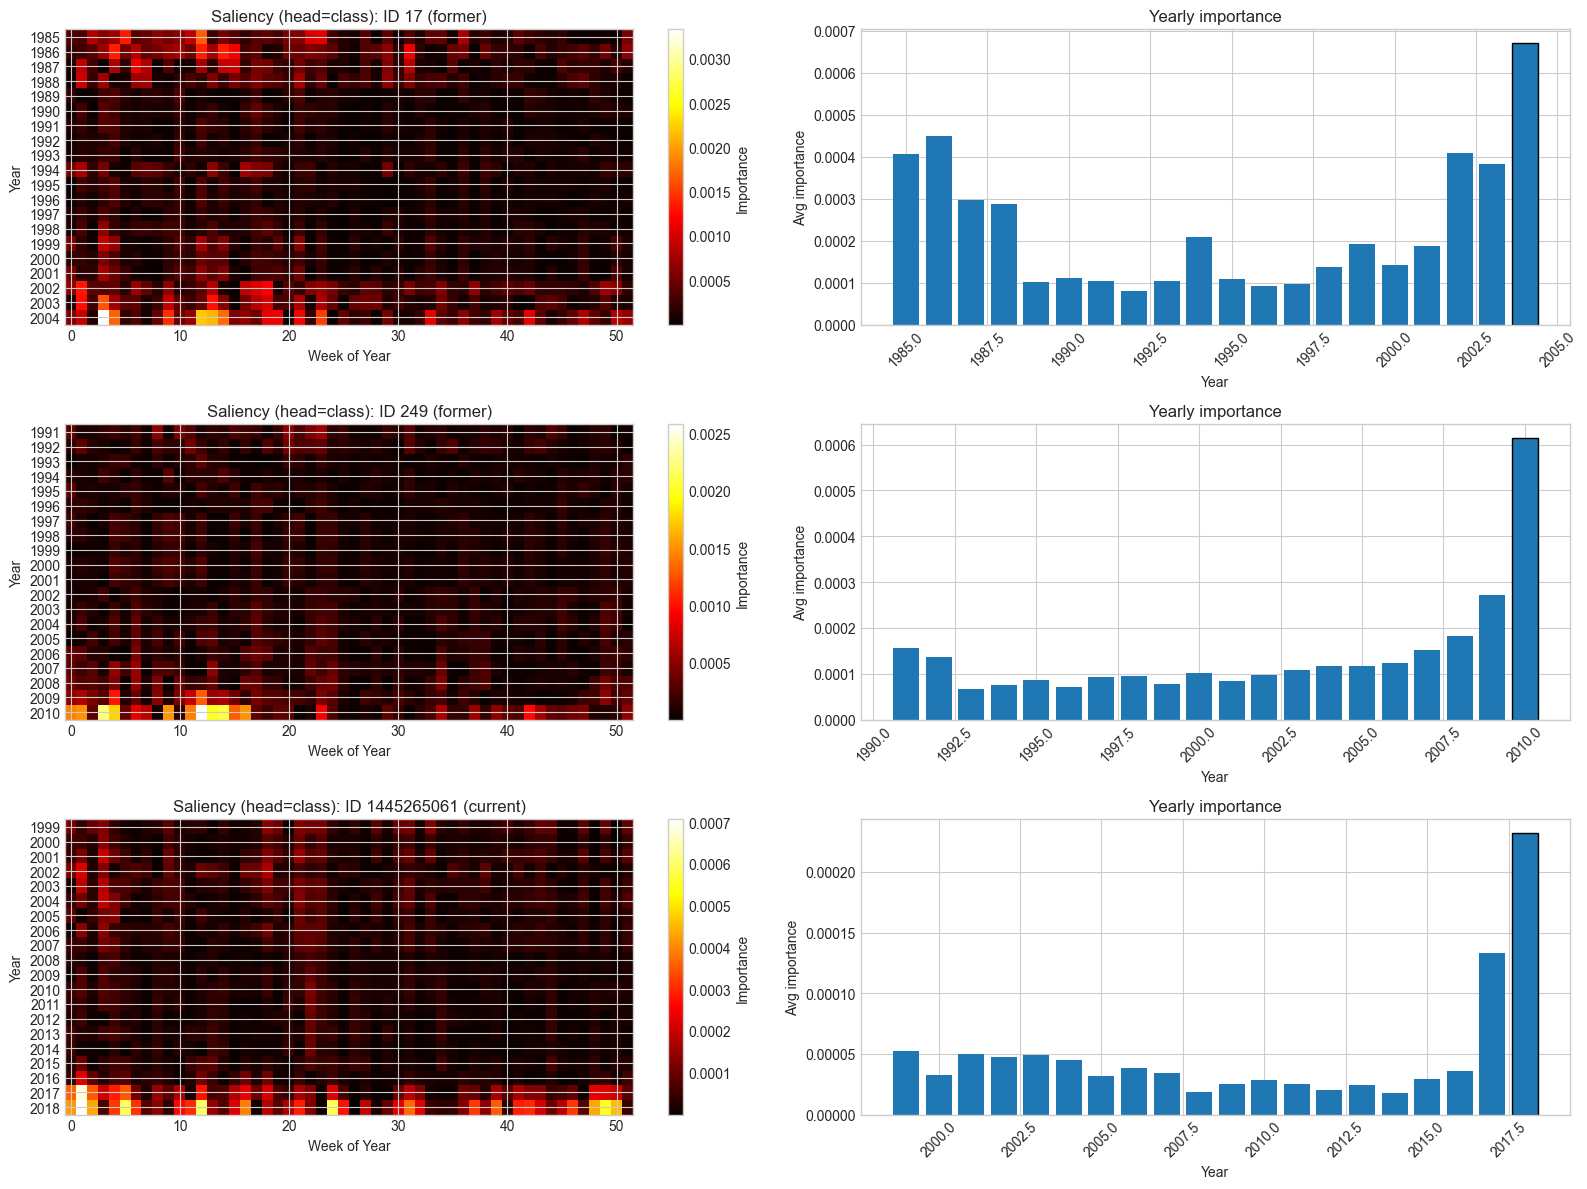

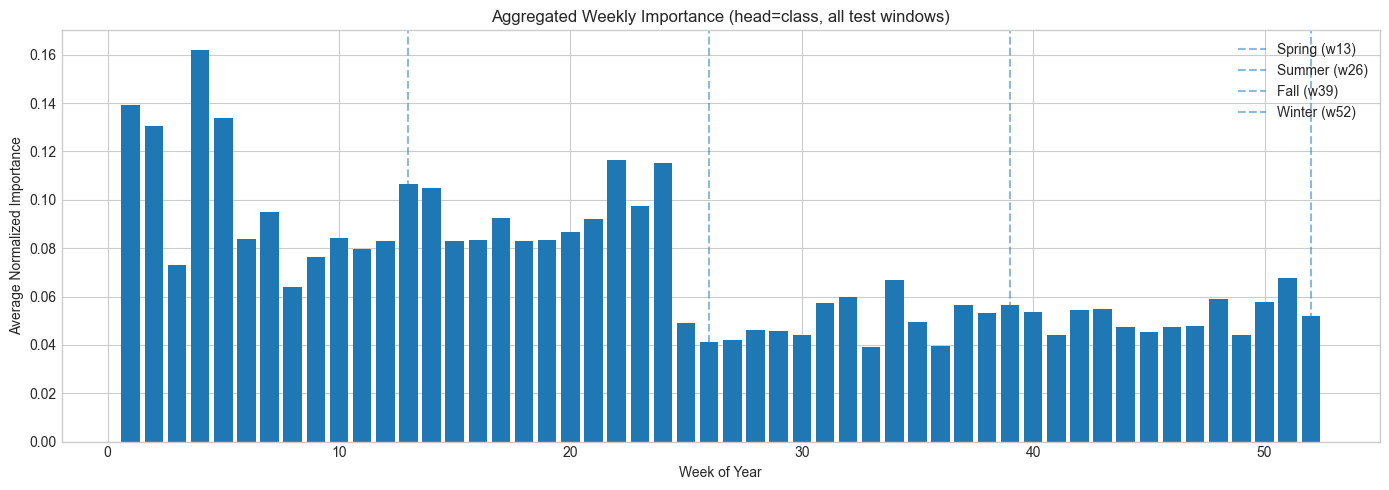

Top 5 most important weeks:
  Week 4: importance = 0.1620
  Week 1: importance = 0.1392
  Week 5: importance = 0.1337
  Week 2: importance = 0.1307
  Week 22: importance = 0.1165

=== END FEATURE IMPORTANCE ===


In [13]:
# =============================================================================
# 10. FEATURE IMPORTANCE - Gradient-based saliency maps (Multi-Task)
# =============================================================================
# We compute saliency w.r.t. the SEQUENCE input (weather) while conditioning on geo.
# By default we explain the classification head (probability of closed_target).


def compute_saliency(model, X_seq, X_static, head: str = 'class', timestep: int = -1):
    """Gradient-based saliency for a single window.

    Returns abs gradient of selected output (class/reg) w.r.t X_seq.
    Shape: (T, 52) => importance of each week in each year (T = sequence length).
    """
    X_seq_tensor = tf.convert_to_tensor(np.expand_dims(X_seq, 0), dtype=tf.float32)
    X_static_tensor = tf.convert_to_tensor(np.expand_dims(X_static, 0), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(X_seq_tensor)
        class_out, reg_out = model.model({'seq_in': X_seq_tensor, 'static_in': X_static_tensor}, training=False)

        if head == 'class':
            target = class_out[0, timestep, 0]
        elif head == 'reg':
            target = reg_out[0, timestep, 0]
        else:
            raise ValueError("head must be 'class' or 'reg'")

    grads = tape.gradient(target, X_seq_tensor)
    saliency = np.abs(grads.numpy()[0])
    return saliency


def plot_saliency_heatmaps(X_seq_test, X_static_test, meta_test, model, head: str = 'class', n_samples: int = 3):
    """Plot saliency heatmaps for a few sample resorts."""
    former_indices = [i for i, m in enumerate(meta_test) if m['resort_type'] == 'former']
    current_indices = [i for i, m in enumerate(meta_test) if m['resort_type'] == 'current']

    sample_indices = []
    if len(former_indices) >= 2:
        sample_indices.extend(np.random.choice(former_indices, min(2, len(former_indices)), replace=False))
    if len(current_indices) >= 1:
        sample_indices.extend(np.random.choice(current_indices, min(1, len(current_indices)), replace=False))

    n_samples = len(sample_indices)
    if n_samples == 0:
        print("No samples available for saliency visualization.")
        return

    fig, axes = plt.subplots(n_samples, 2, figsize=(16, 4 * n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for plot_idx, sample_idx in enumerate(sample_indices):
        Xw = X_seq_test[sample_idx]
        Xs = X_static_test[sample_idx]
        years = np.array(meta_test[sample_idx]['years'], dtype=int)
        resort_type = meta_test[sample_idx]['resort_type']
        resort_id = meta_test[sample_idx]['id']

        saliency = compute_saliency(model, Xw, Xs, head=head, timestep=-1)

        ax1 = axes[plot_idx, 0]
        im1 = ax1.imshow(saliency, aspect='auto', cmap='hot', interpolation='nearest')
        ax1.set_xlabel('Week of Year')
        ax1.set_ylabel('Year')
        ax1.set_yticks(range(len(years)))
        ax1.set_yticklabels(years)
        ax1.set_title(f"Saliency (head={head}): ID {resort_id} ({resort_type})")
        plt.colorbar(im1, ax=ax1, label='Importance')

        ax2 = axes[plot_idx, 1]
        yearly_importance = saliency.mean(axis=1)
        bars = ax2.bar(years, yearly_importance)
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Avg importance')
        ax2.set_title('Yearly importance')
        ax2.tick_params(axis='x', rotation=45)

        max_year_idx = int(np.argmax(yearly_importance))
        bars[max_year_idx].set_edgecolor('black')

    plt.tight_layout()
    plt.show()


def plot_aggregated_weekly_importance(X_seq_test, X_static_test, model, head: str = 'class'):
    """Aggregate saliency across all test windows to see which weeks matter most."""
    all_saliencies = []

    for i in range(len(X_seq_test)):
        saliency = compute_saliency(model, X_seq_test[i], X_static_test[i], head=head, timestep=-1)
        saliency_norm = saliency / (saliency.max() + 1e-8)
        all_saliencies.append(saliency_norm.mean(axis=0))

    avg_weekly = np.mean(all_saliencies, axis=0)

    fig, ax = plt.subplots(figsize=(14, 5))
    weeks = np.arange(1, 53)
    ax.bar(weeks, avg_weekly)
    ax.set_xlabel('Week of Year')
    ax.set_ylabel('Average Normalized Importance')
    ax.set_title(f'Aggregated Weekly Importance (head={head}, all test windows)')

    ax.axvline(x=13, linestyle='--', alpha=0.5, label='Spring (w13)')
    ax.axvline(x=26, linestyle='--', alpha=0.5, label='Summer (w26)')
    ax.axvline(x=39, linestyle='--', alpha=0.5, label='Fall (w39)')
    ax.axvline(x=52, linestyle='--', alpha=0.5, label='Winter (w52)')
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    top_weeks = np.argsort(avg_weekly)[::-1][:5]
    print("Top 5 most important weeks:")
    for w in top_weeks:
        print(f"  Week {w+1}: importance = {avg_weekly[w]:.4f}")


print("=== FEATURE IMPORTANCE VISUALIZATION (Multi-Task) ===\n")
print("Computing gradient-based saliency maps (classification head)...")

plot_saliency_heatmaps(X_seq_test, X_static_test, meta_test, shutdown_model, head='class', n_samples=3)
plot_aggregated_weekly_importance(X_seq_test, X_static_test, shutdown_model, head='class')

print("\n=== END FEATURE IMPORTANCE ===")


In [19]:
# =============================================================================
# 11. FUTURE INFERENCE - predicted_ski_weather -> shutdown_predictions (Hopsworks)
# =============================================================================
# Output schema (as requested):
# - ski_resort_id: id from ski_weather / predicted_ski_weather
# - will_shutdown: 1 if predicted shutdown within 30 years, else 0
# - shutdown_year: calendar year of first predicted shutdown; 0 if will_shutdown=0

PROB_THRESHOLD = 0.5
HORIZON_YEARS = 30

print("\n=== FUTURE INFERENCE: predicted_ski_weather ===")

# 1) Read predicted future weather
pred_fg = fs.get_feature_group(name='predicted_ski_weather', version=1)
pred_df = pred_fg.read()

required_cols = {'date', 'ski_resort_id', 'mean_week_temperature'}
missing = required_cols - set(pred_df.columns)
if missing:
    raise ValueError(f"predicted_ski_weather is missing required columns: {missing}")

pred_df = pred_df[list(required_cols)].copy()
pred_df['date'] = pd.to_datetime(pred_df['date'])
pred_df['ski_resort_id'] = pred_df['ski_resort_id'].astype(int)
pred_df = pred_df.sort_values(['ski_resort_id', 'date']).reset_index(drop=True)
pred_df['year'] = pred_df['date'].dt.year.astype(int)

# 2) Attach geo (lat/lon) using the same lookup as training (current_resorts + former_resorts)
if 'meta_geo' not in globals():
    raise RuntimeError("meta_geo not found. Re-run the data ingestion section so meta_geo is created.")

pred_df = pred_df.merge(
    meta_geo[['ski_resort_id', 'latitude', 'longitude']],
    on='ski_resort_id',
    how='left',
)

missing_geo = pred_df.loc[pred_df['latitude'].isna() | pred_df['longitude'].isna(), 'ski_resort_id'].nunique()
if missing_geo > 0:
    print(f"Warning: dropping {missing_geo} resorts with missing latitude/longitude in meta_geo")

# Drop resorts without geo
pred_df = pred_df.dropna(subset=['latitude', 'longitude']).copy()

# 3) Build per-resort (T, 52) sequences (T = number of forecast years available)
results = []
resort_ids = sorted(pred_df['ski_resort_id'].unique().tolist())

for rid in resort_ids:
    rdf = pred_df[pred_df['ski_resort_id'] == rid]

    lat = float(rdf['latitude'].iloc[0])
    lon = float(rdf['longitude'].iloc[0])
    years = sorted(rdf['year'].unique().tolist())

    # Build one 52-week vector per calendar year
    X_years = []
    for y in years:
        ydf = rdf[rdf['year'] == y].sort_values('date')
        temps = ydf['mean_week_temperature'].values.astype(np.float32)

        # Pad/truncate to 52 weeks (within-year padding only) - same logic as training
        if len(temps) < 52:
            temps = np.pad(temps, (0, 52 - len(temps)), mode='edge')
        elif len(temps) > 52:
            temps = temps[:52]

        X_years.append(temps)

    X_seq = np.array(X_years, dtype=np.float32)  # (T, 52)

    # Normalize using TRAIN scalers from earlier in the notebook
    if 'seq_mean' not in globals() or 'seq_std' not in globals() or 'static_mean' not in globals() or 'static_std' not in globals():
        raise RuntimeError("Scalers (seq_mean/seq_std/static_mean/static_std) not found. Re-run preprocessing + scaling section.")

    X_seq_n = (X_seq - seq_mean) / seq_std
    X_static = np.array([lat, lon], dtype=np.float32)
    X_static_n = (X_static - static_mean) / static_std

    # Predict
    class_p, _reg_y = shutdown_model.predict(X_seq_n, X_static_n)  # supports any T
    p = class_p[0, :, 0]

    # will_shutdown within next HORIZON_YEARS (or fewer if forecast is shorter)
    horizon = min(HORIZON_YEARS, len(years))
    shutdown_idx = np.where(p[:horizon] >= PROB_THRESHOLD)[0]

    if len(shutdown_idx) > 0:
        will_shutdown = 1
        shutdown_year = int(years[int(shutdown_idx[0])])
    else:
        will_shutdown = 0
        shutdown_year = 0

    results.append({
        'ski_resort_id': int(rid),
        'will_shutdown': int(will_shutdown),
        'shutdown_year': int(shutdown_year),
    })

shutdown_predictions_df = pd.DataFrame(results).sort_values('ski_resort_id').reset_index(drop=True)

# Hopsworks FG schema often uses 32-bit int; make dtypes explicit to avoid bigint mismatch
shutdown_predictions_df = shutdown_predictions_df.astype({
    'ski_resort_id': 'int32',
    'will_shutdown': 'int32',
    'shutdown_year': 'int32',
})

print(f"Resorts in predicted_ski_weather (after geo join): {len(shutdown_predictions_df)}")
print("will_shutdown distribution:")
print(shutdown_predictions_df['will_shutdown'].value_counts(dropna=False))

# 4) Upload to Hopsworks Feature Group: shutdown_predictions (version 1)
shutdown_predictions_fg = fs.get_or_create_feature_group(
    name='shutdown_predictions',
    description='Shutdown predictions from LSTM multi-task model (inference on predicted_ski_weather)',
    version=1,
    primary_key=['ski_resort_id'],
)
shutdown_predictions_fg.insert(shutdown_predictions_df)

print(f"Uploaded {len(shutdown_predictions_df)} rows to shutdown_predictions v1 successfully.")
shutdown_predictions_df.head(10)




=== FUTURE INFERENCE: predicted_ski_weather ===
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.42s) 
Resorts in predicted_ski_weather (after geo join): 100
will_shutdown distribution:
will_shutdown
1    57
0    43
Name: count, dtype: int64


Uploading Dataframe: 100.00% |██████████| Rows 100/100 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: shutdown_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271967/jobs/named/shutdown_predictions_1_offline_fg_materialization/executions
Uploaded 100 rows to shutdown_predictions v1 successfully.


,ski_resort_id,will_shutdown,shutdown_year
0,7752047,1,2035
1,7768194,0,0
2,10356621,1,2033
3,10356626,1,2033
4,13766277,0,0
5,32150269,1,2034
6,45094892,0,0
7,45117869,0,0
8,45146740,1,2036
9,45147901,1,2035
